In [1]:
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw


import numpy as np
import matplotlib.pyplot as plt

import torch
from src import const
from rdkit.Chem.Draw import rdMolDraw2D

from PIL import Image

from src.molecule_builder import get_bond_order

from src.datasets import get_dataloader
from src.lightning import DDPM

import yaml

In [2]:
def load_molecule_xyz(file, is_geom):
    atom2idx = const.GEOM_ATOM2IDX if is_geom else const.ATOM2IDX
    idx2atom = const.GEOM_IDX2ATOM if is_geom else const.IDX2ATOM
    with open(file, encoding='utf8') as f:
        n_atoms = int(f.readline())
        one_hot = torch.zeros(n_atoms, len(idx2atom))
        charges = torch.zeros(n_atoms, 1)
        positions = torch.zeros(n_atoms, 3)
        f.readline()
        atoms = f.readlines()
        for i in range(n_atoms):
            atom = atoms[i].split(' ')
            atom_type = atom[0]
            one_hot[i, atom2idx[atom_type]] = 1
            position = torch.Tensor([float(e) for e in atom[1:]])
            positions[i, :] = position
        return positions, one_hot, charges

In [3]:
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)
    
COORDINATES_FOLDER = "trajectories/zinc_difflinker/zinc_final_test/chains_hausdorff_distance_0.5_seed_42_no_transform_transformation_seed_42_COM_addition_alternate_viz/"
SHAPLEY_VALUES_FOLDER = "results/shapley_values/"
NUM_SAMPLES = config['NUM_SAMPLES']
IDX2ATOM = {0: 'C', 1: 'O', 2: 'N', 3: 'F', 4: 'S', 5: 'Cl', 6: 'Br', 7: 'I'}

checkpoint = config['CHECKPOINT']
DATA = config['DATA']
prefix = config['PREFIX']
device = config['DEVICE'] if torch.cuda.is_available() else 'cpu'
NUM_SAMPLES = config['NUM_SAMPLES']
SEED_LIST = [42,1240,14085]

model = DDPM.load_from_checkpoint(checkpoint, map_location=device)
model.val_data_prefix = prefix

print(f"Running device: {device}")

if DATA is not None:
    model.data_path = DATA

model = model.eval().to(device)
model.setup(stage='val')
dataloader = get_dataloader(
    model.val_dataset,
    batch_size=1
)

data_list = []
sampled = 0
data_dict = {}
for data in dataloader:
    if sampled < NUM_SAMPLES:
        data_list.append(data)
        sampled += 1

Lightning automatically upgraded your loaded checkpoint from v1.6.3 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint models/zinc_difflinker.ckpt`


Running device: cuda:1


In [4]:
#load shapley values

shapley_values_all_dict = {}

for i in range(NUM_SAMPLES):
    shapley_values_all_dict[i] = []
    
    for seed in SEED_LIST:
        shapley_values_seed = []
        with open(f"{SHAPLEY_VALUES_FOLDER}explanations_hausdorff_distance_0.5_seed_{str(seed)}_no_transform_transformation_seed_42_COM_addition/phi_atoms_{i}.txt", "r") as f:
            f.readline()
            f.readline()
            
            for line in f:
                if line == "\n":
                    break
                row = line.strip().split(",")
                shapley_values_seed.append(float(row[1]))
        shapley_values_all_dict[i].append(shapley_values_seed)
        

/tmp/ipykernel_2396268/2544925074.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm_r') #reversed heatmap for distance-based importance


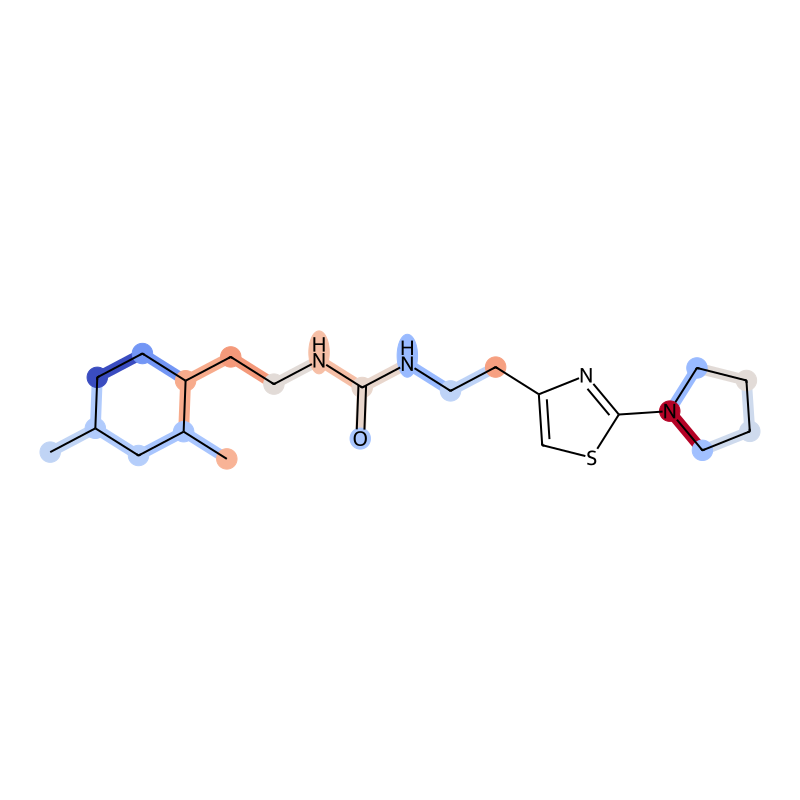

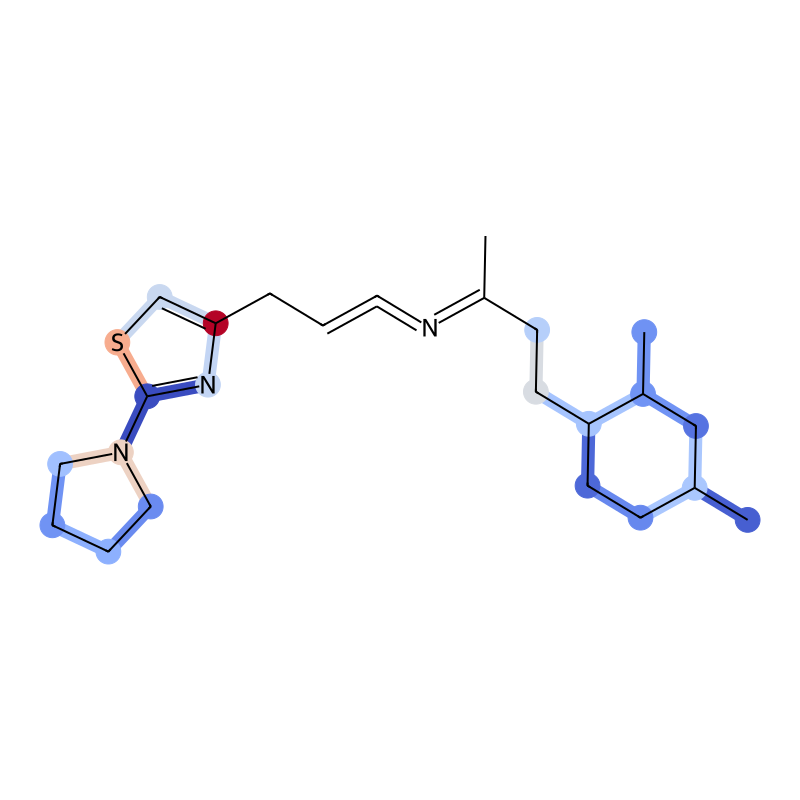

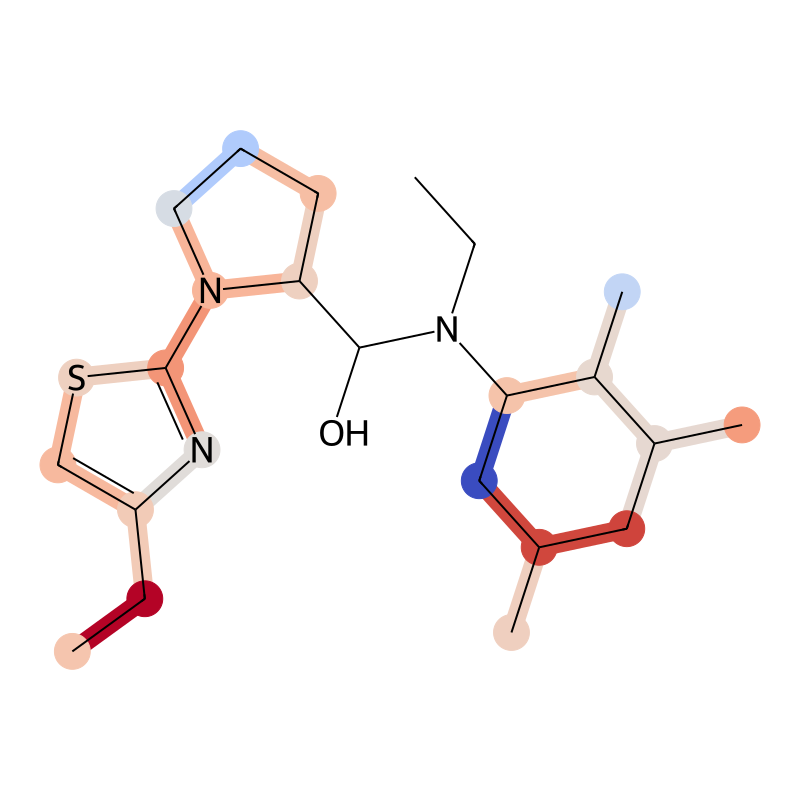

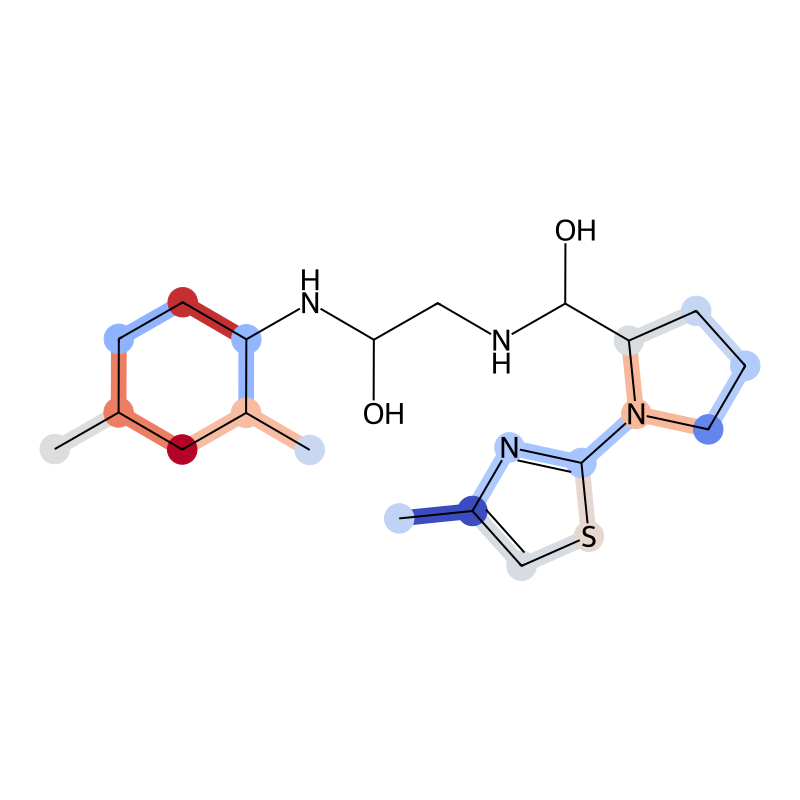

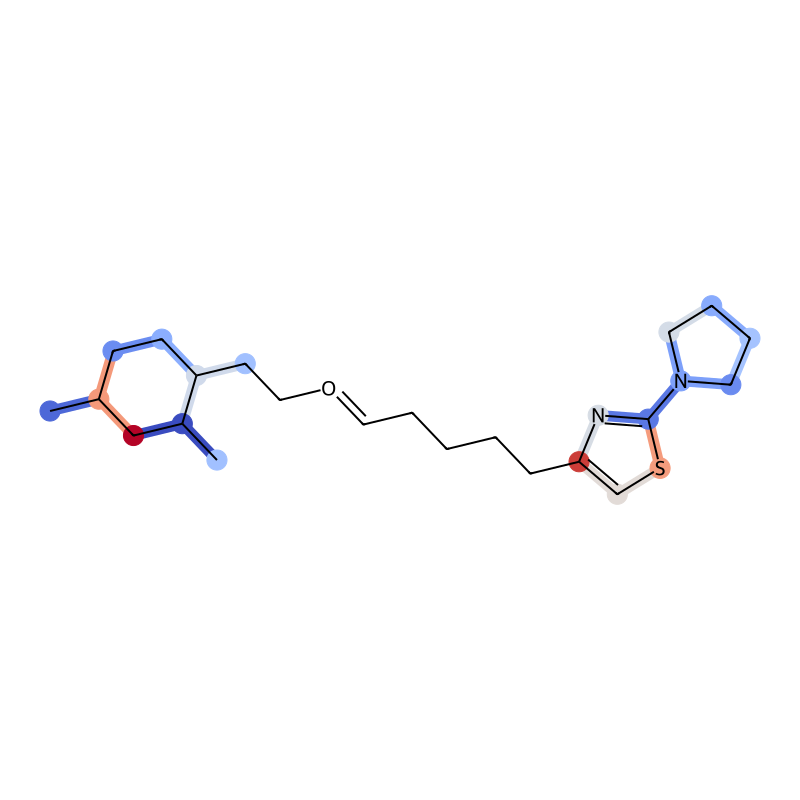

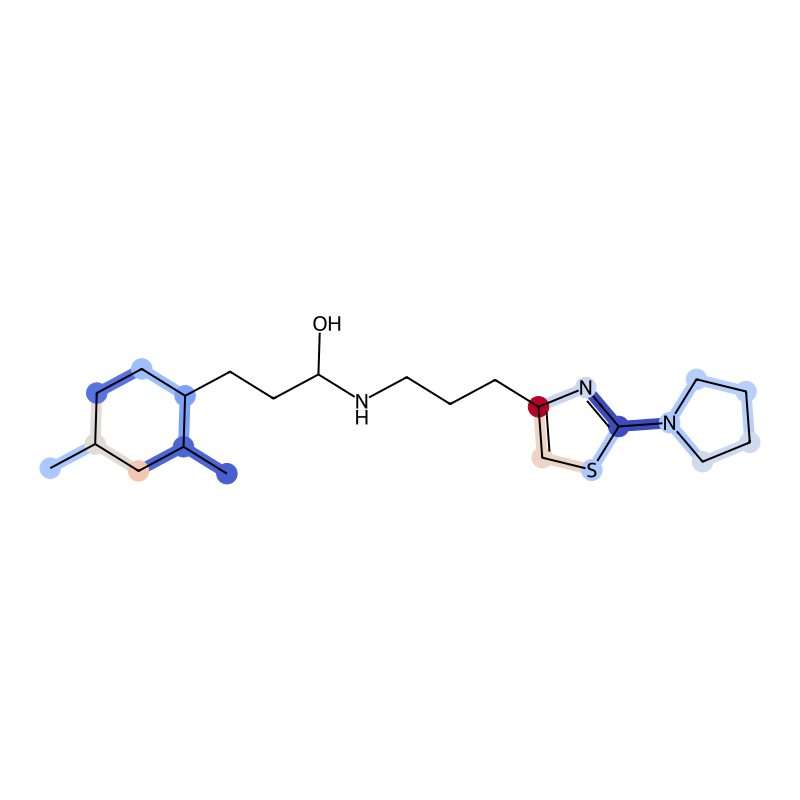

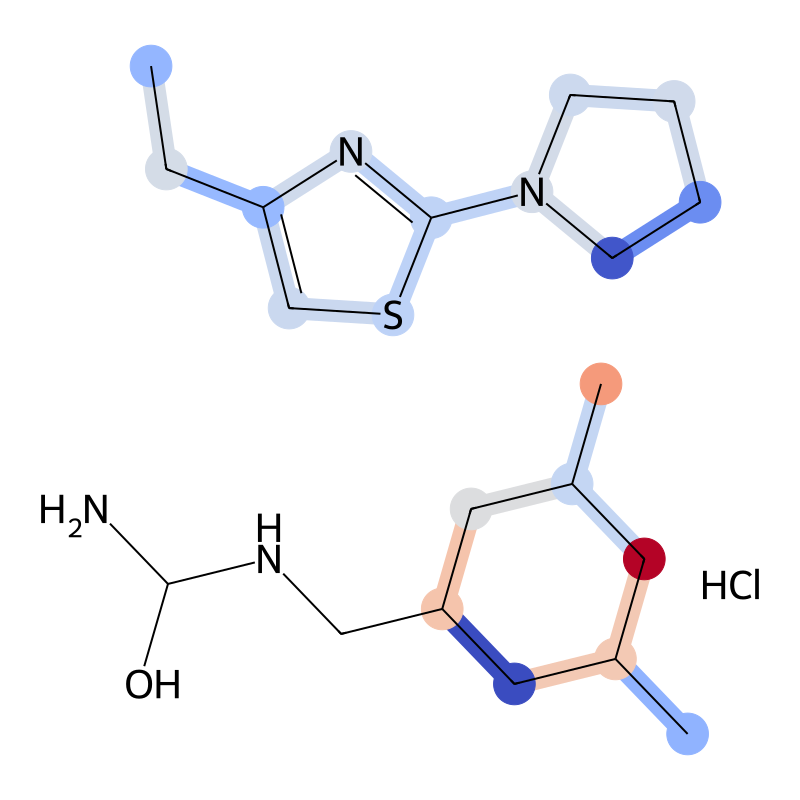

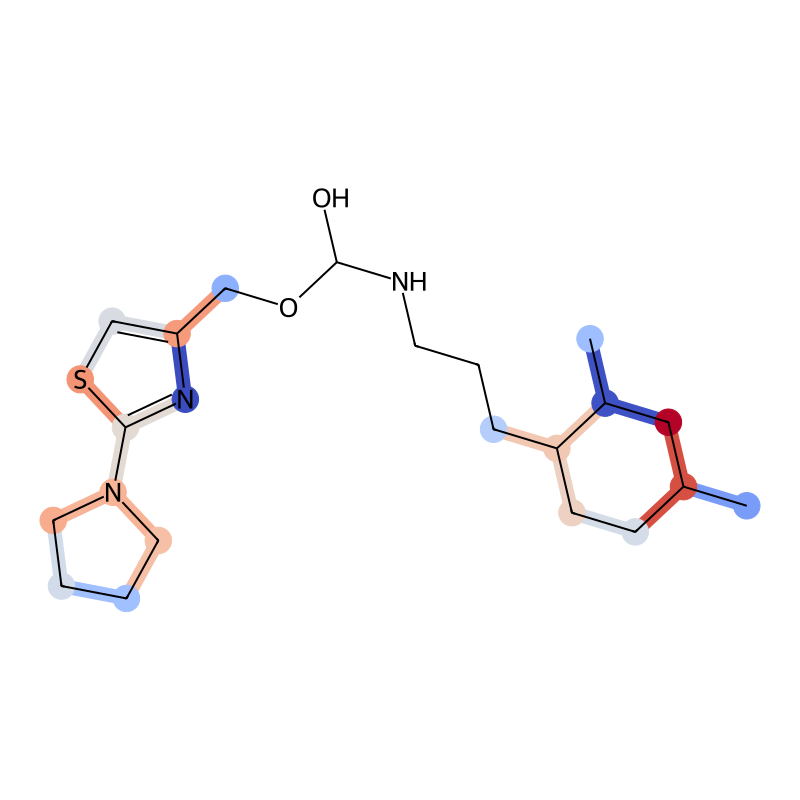

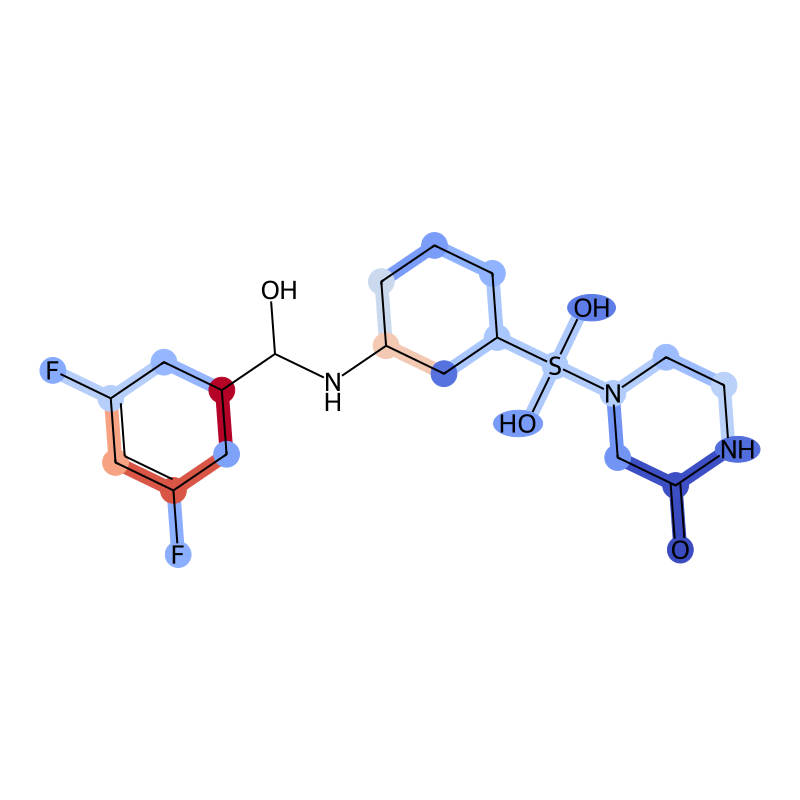

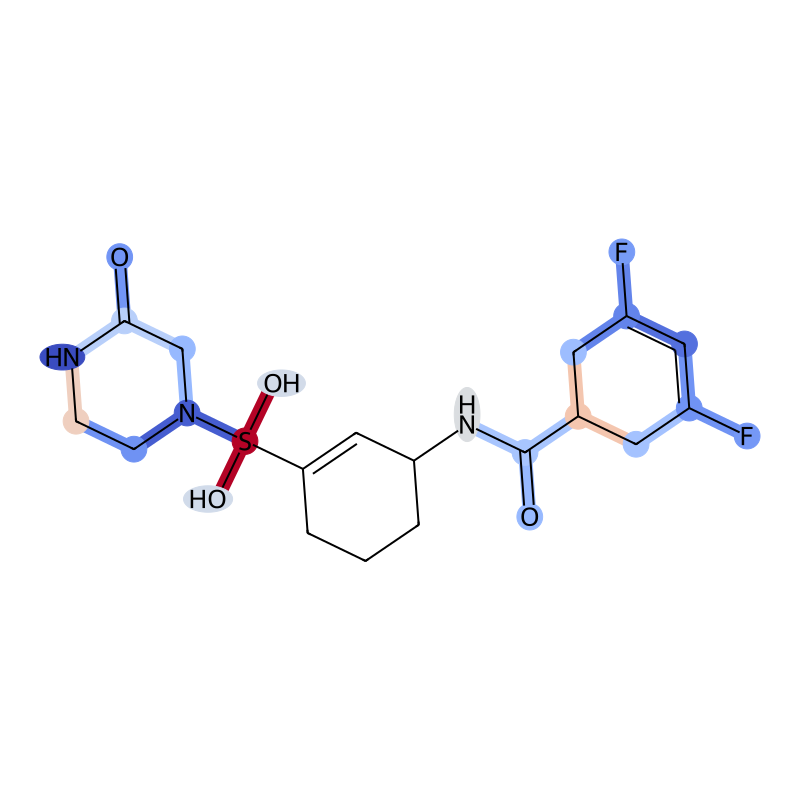

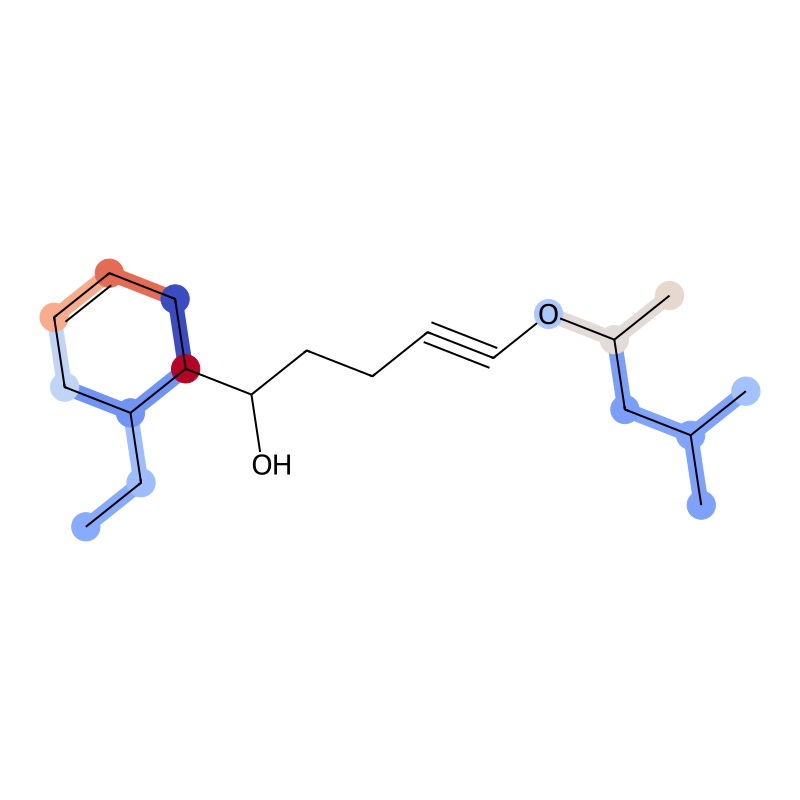

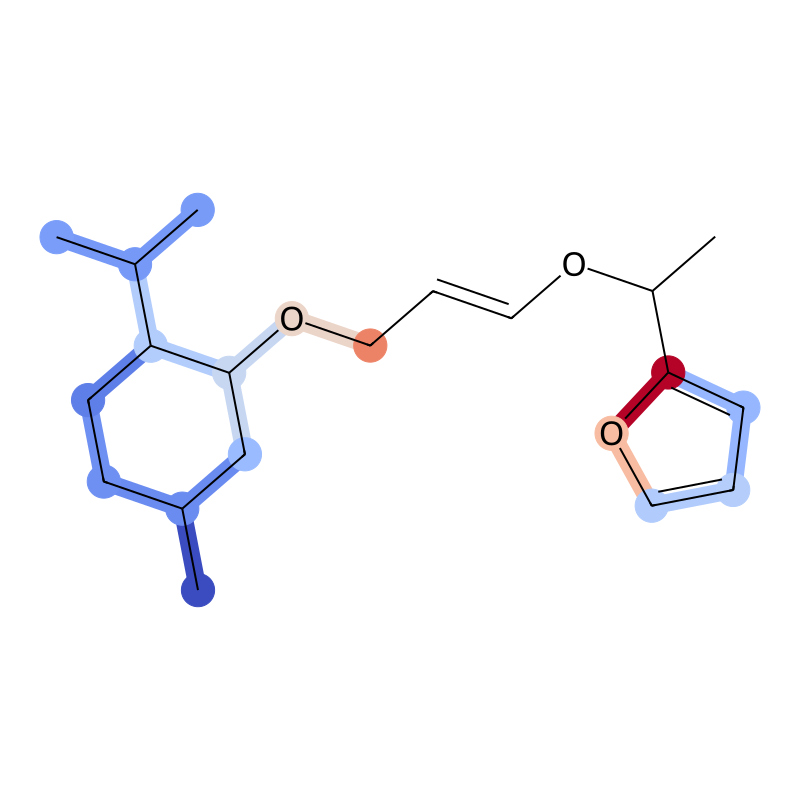

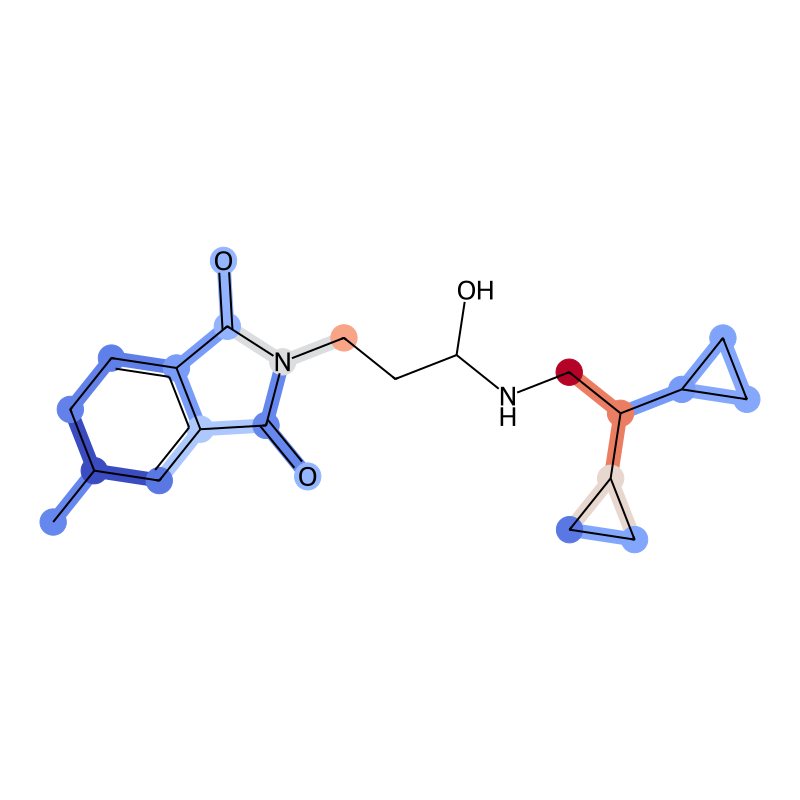

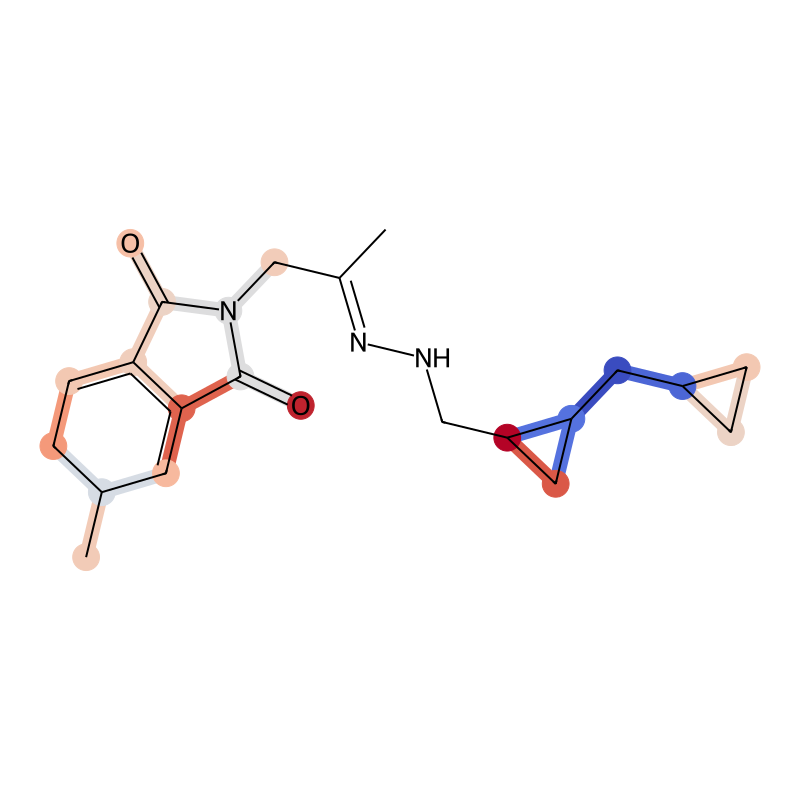

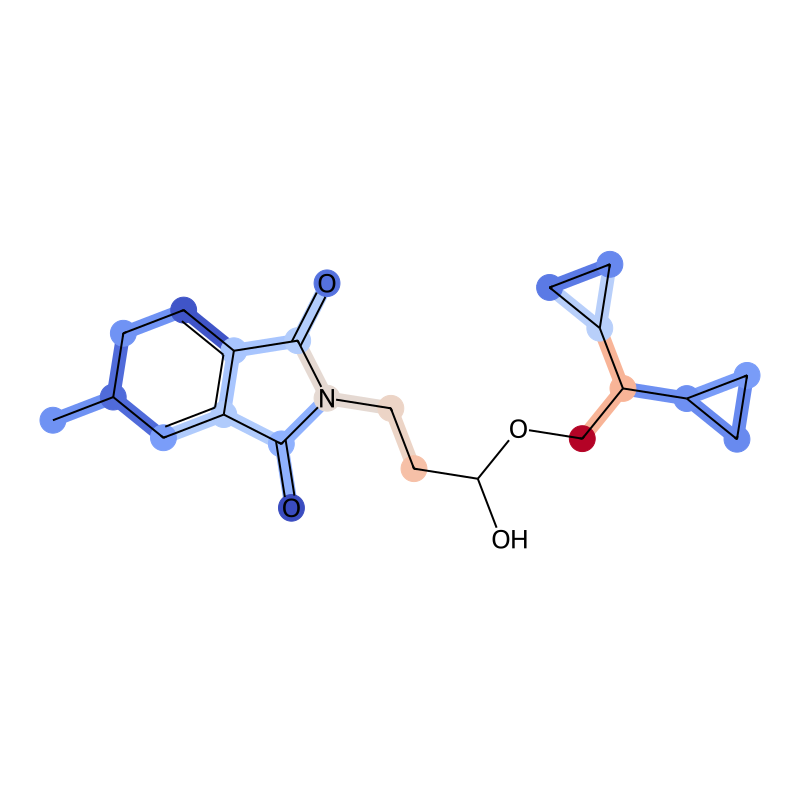

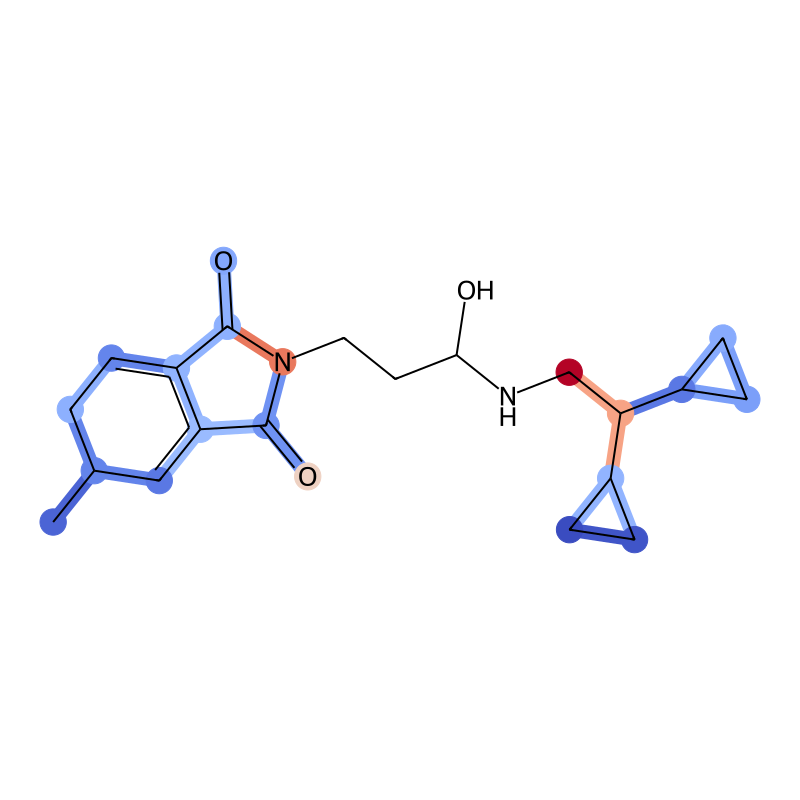

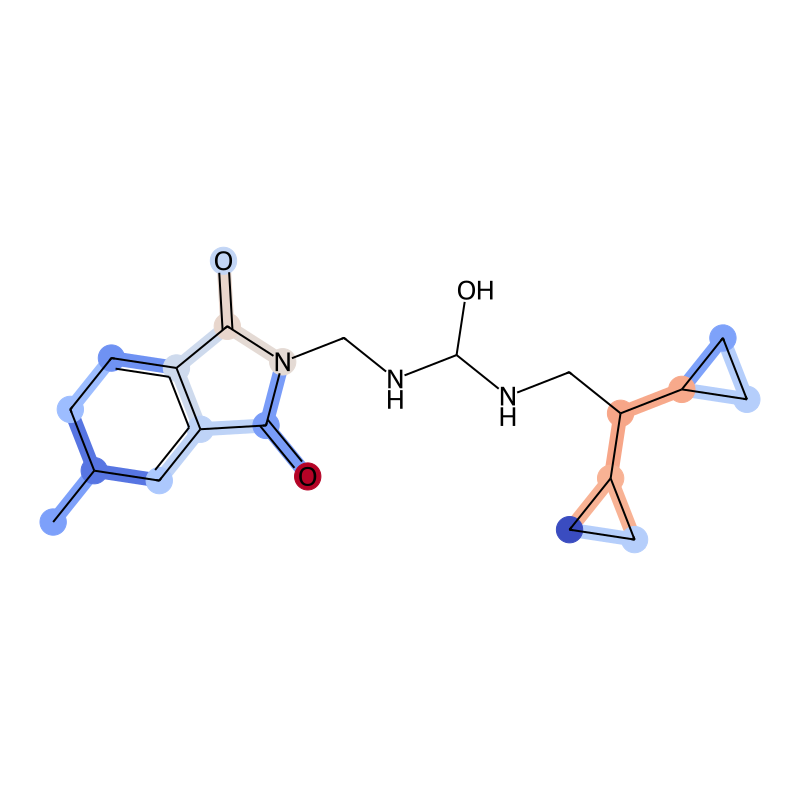

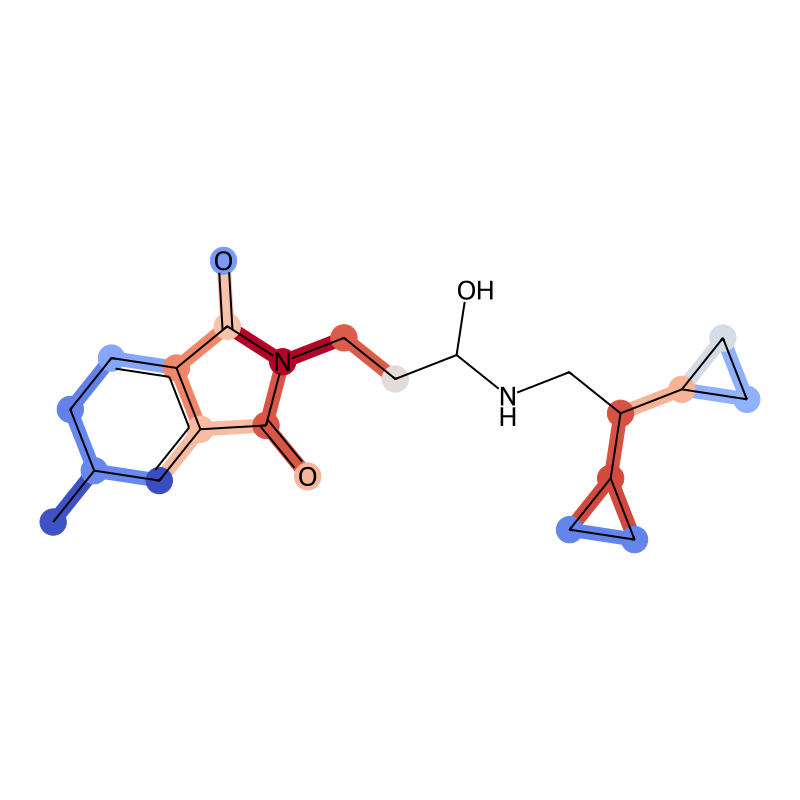

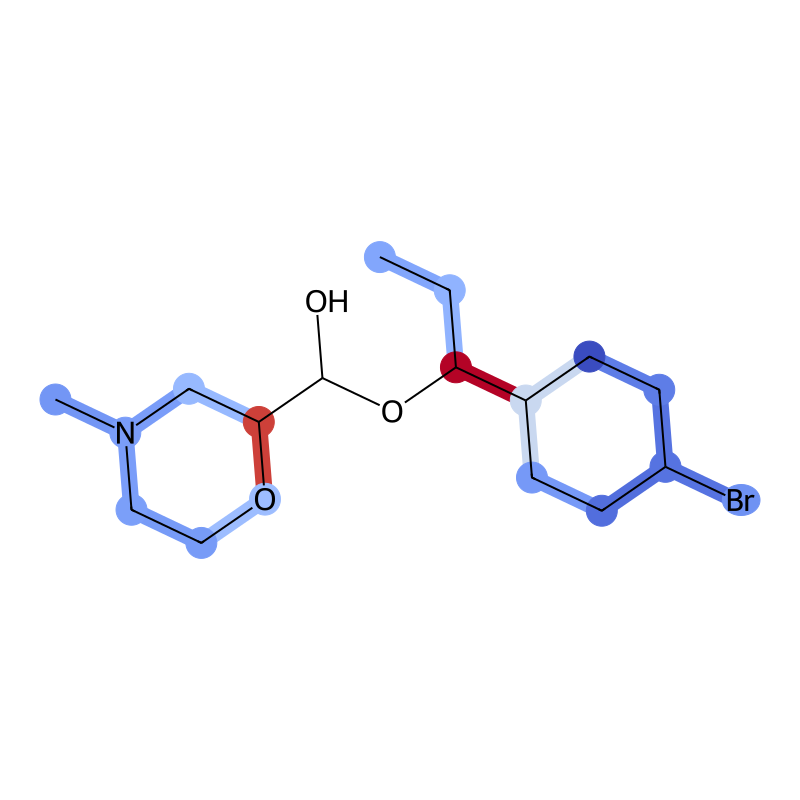

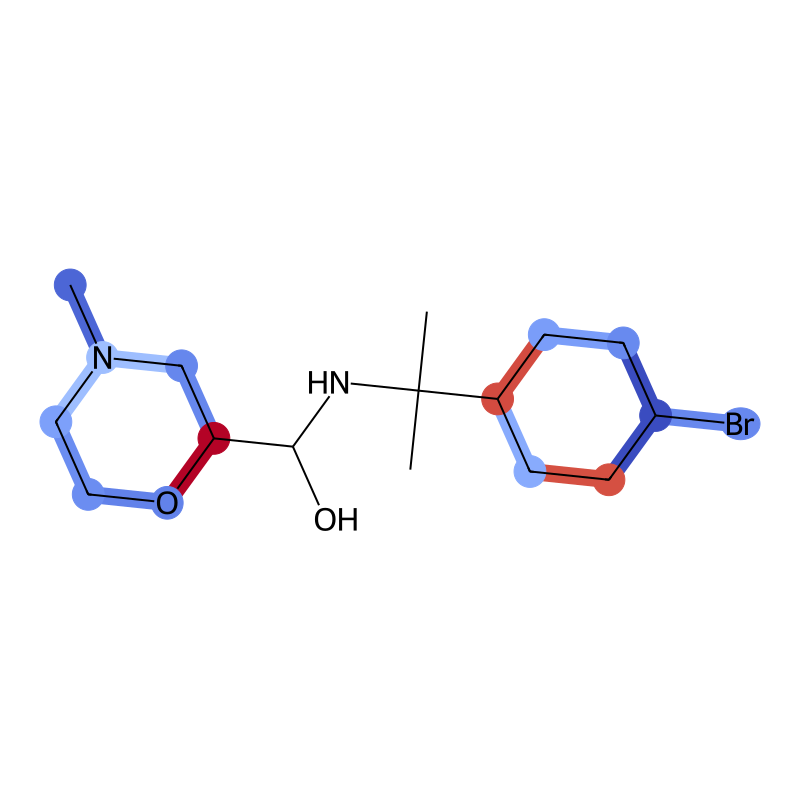

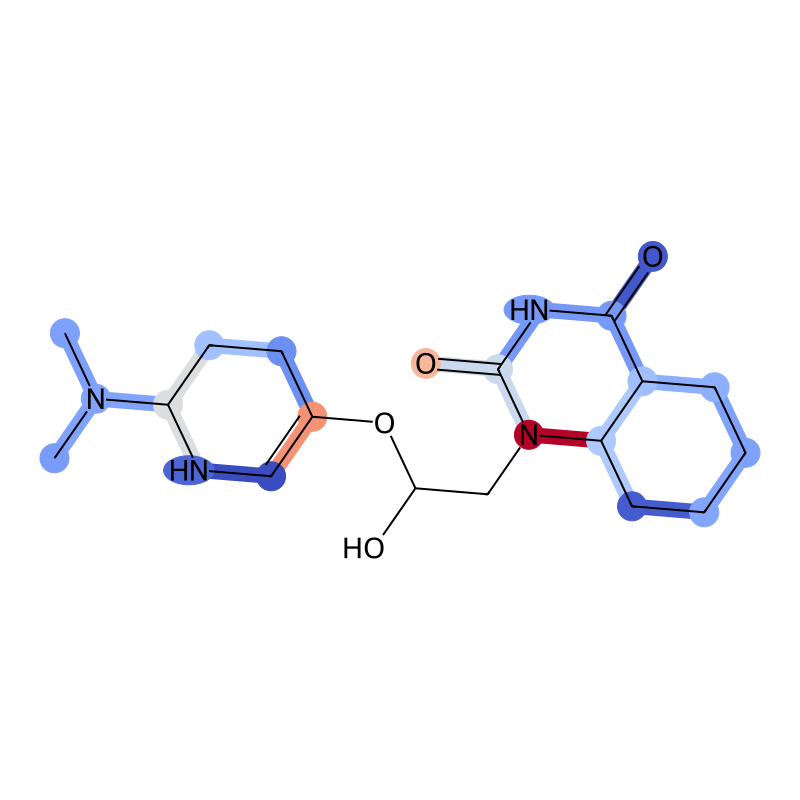

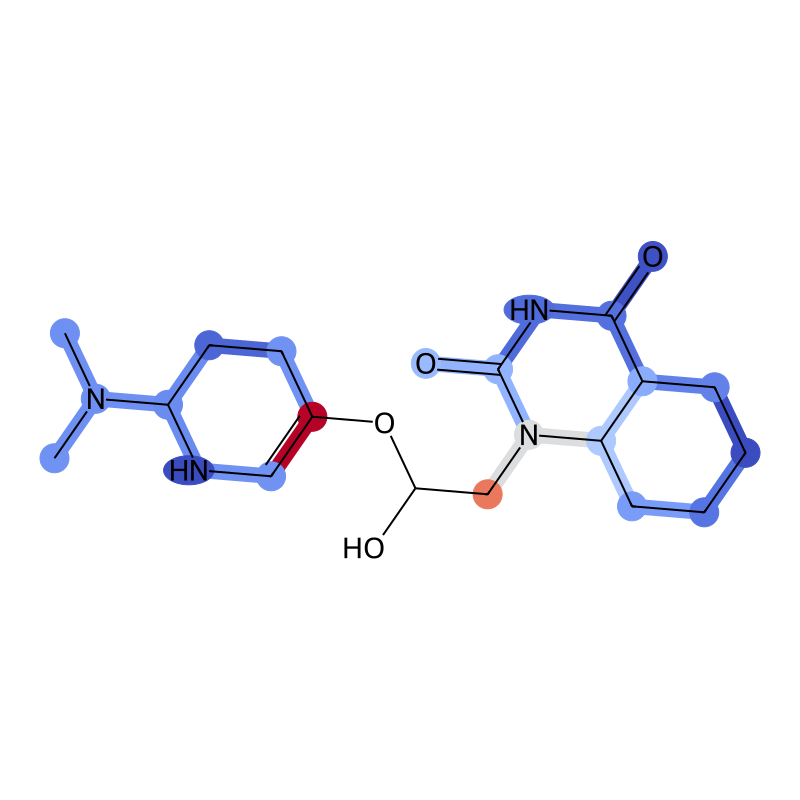

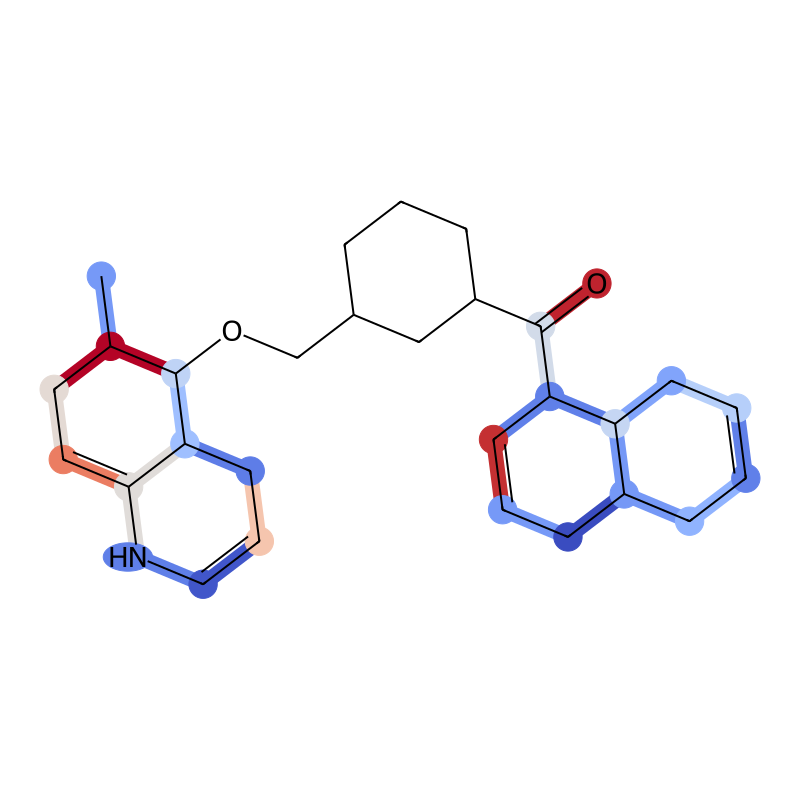

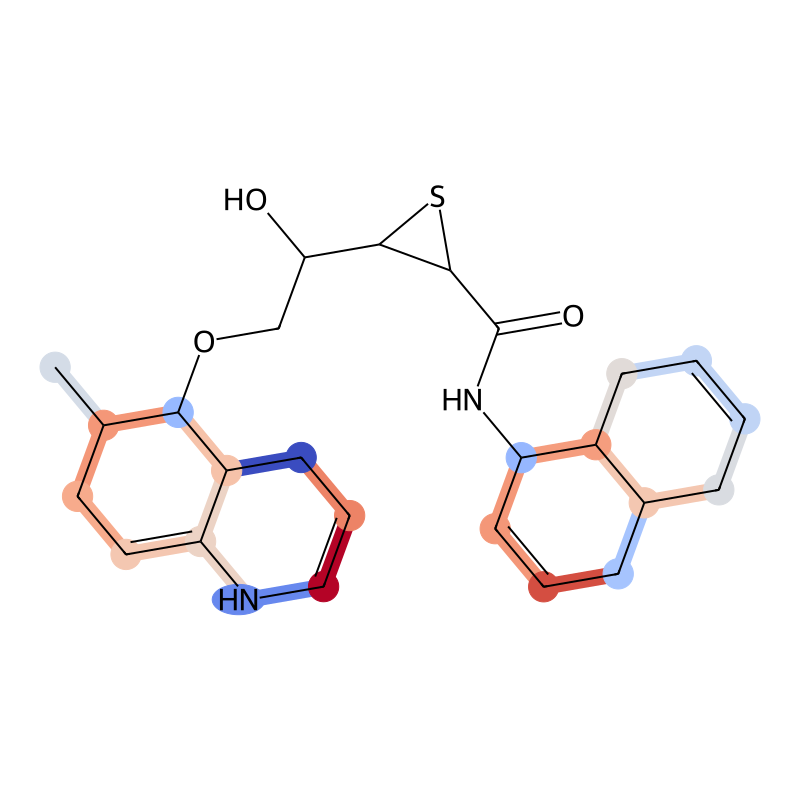

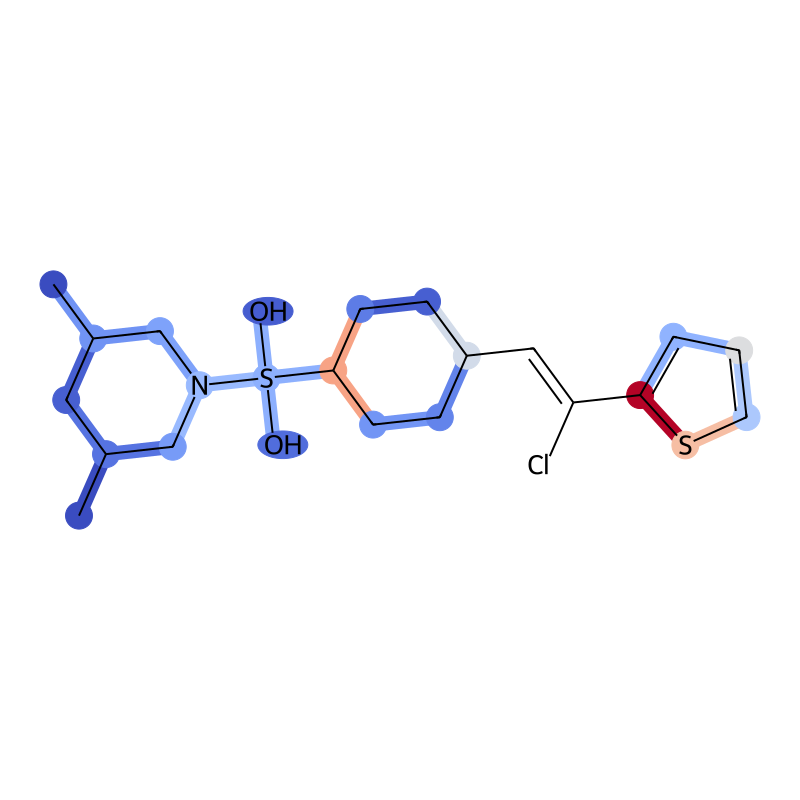

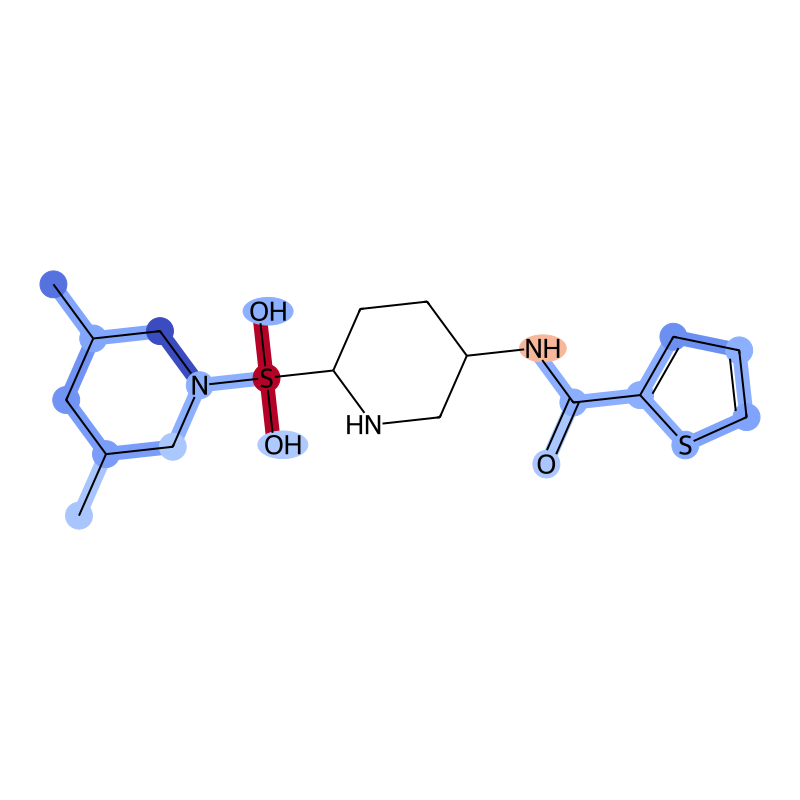

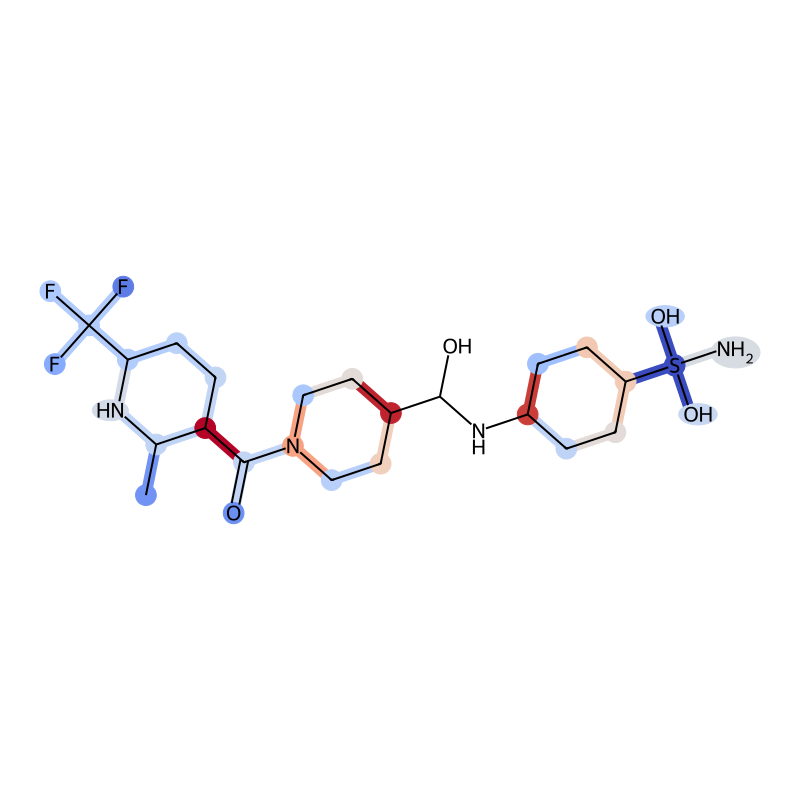

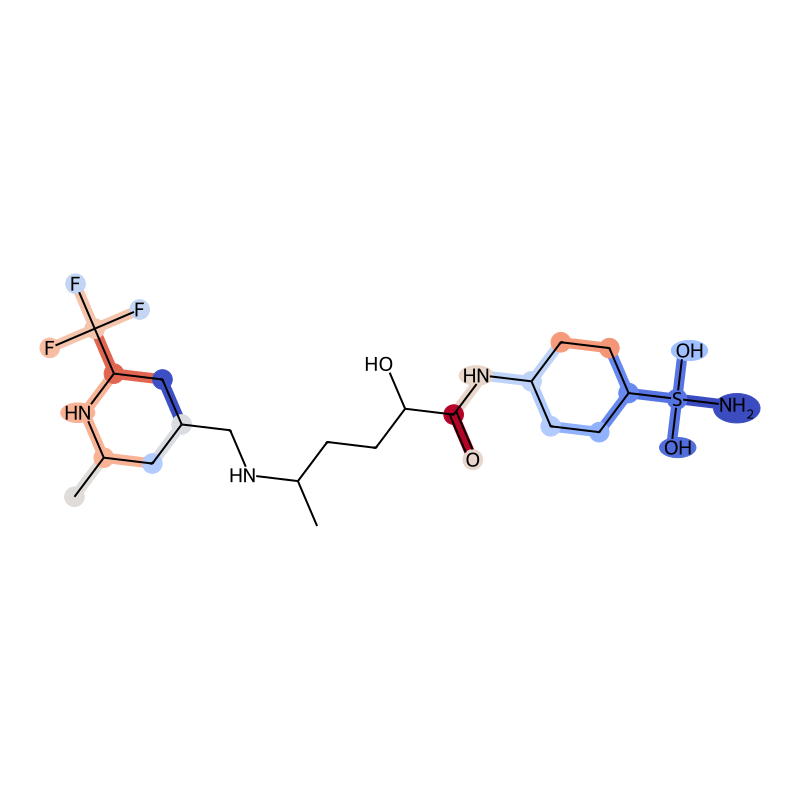

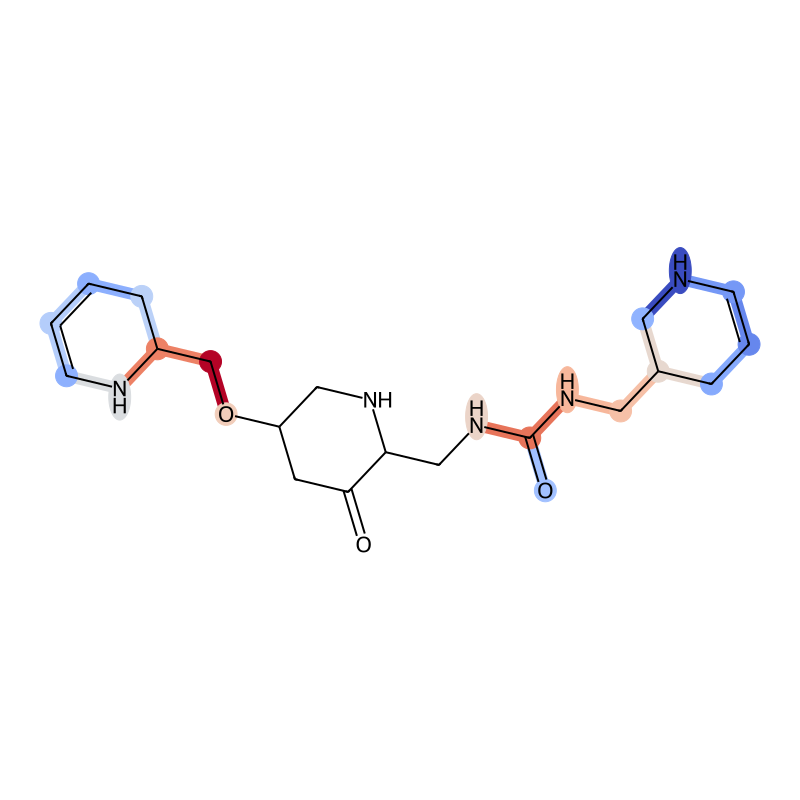

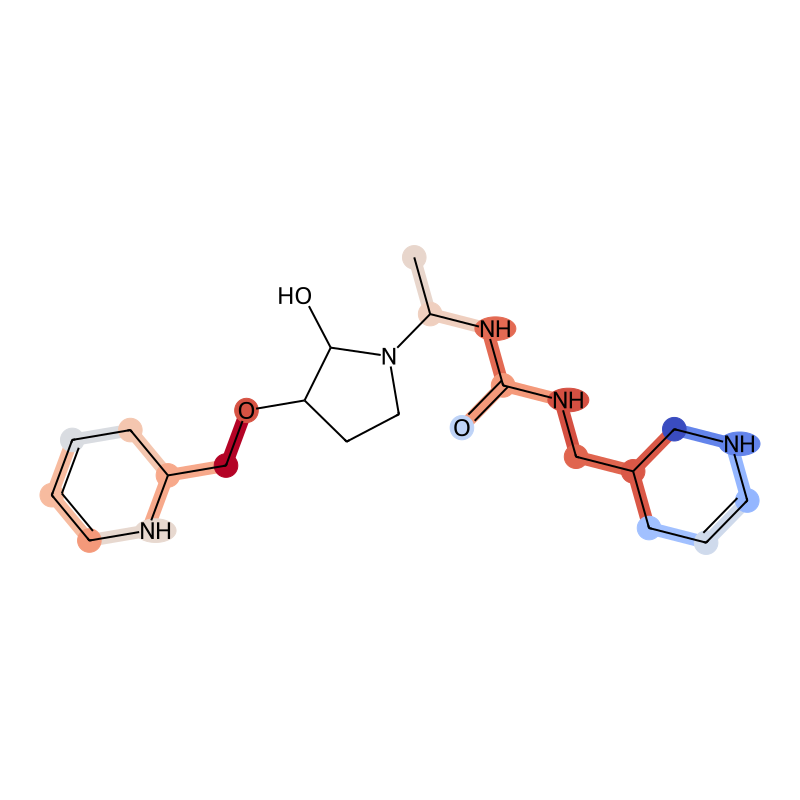

In [31]:
from collections import defaultdict
# Visualize generated molecules as molecular graphs
generated_folder = "trajectories/zinc_difflinker/zinc_final_test/final_states_hausdorff_distance_0.5_seed_42_no_transform_transformation_seed_42_COM_addition"

for data_index, data in enumerate(data_list):
    phi_values = shapley_values_all_dict[data_index][0]
    # Load generated molecule positions and atom types
    generated_file = os.path.join(generated_folder, f"{data_index}_pred_.xyz")
    positions, one_hot, _ = load_molecule_xyz(generated_file, is_geom=False)
    
    atom_types = torch.argmax(one_hot, dim=1).cpu().numpy()
   
    # Convert positions and atom types to an RDKit molecule
    mol = Chem.RWMol()
    atom_map = {}

    # Add atoms to the molecule
    for idx, atom_type in enumerate(atom_types):
        atom = Chem.Atom(IDX2ATOM[atom_type])
        atom_idx = mol.AddAtom(atom)
        atom_map[idx] = atom_idx

    # Add bonds based on positions and bond order
    for idx1 in range(len(positions)):
        for idx2 in range(idx1 + 1, len(positions)):
            dist = np.linalg.norm(positions[idx1] - positions[idx2])
            bond_order = get_bond_order(IDX2ATOM[atom_types[idx1]], IDX2ATOM[atom_types[idx2]], dist)
            if bond_order > 0:
                mol.AddBond(atom_map[idx1], atom_map[idx2], Chem.BondType.values[bond_order])

    # Highlight fragment atoms and edges
    fragment_mask = data['fragment_mask'][0].cpu().numpy()
   
    # Calculate the gradient colors based on phi values
    phi_values_array = np.array(phi_values)
    
    cmap = plt.cm.get_cmap('coolwarm_r') #reversed heatmap for distance-based importance
    norm = plt.Normalize(vmin=min(phi_values_array), vmax=max(phi_values_array))
    
    highlight_colors = {idx: cmap(norm(phi_values_array[idx])) for idx, mask in enumerate(fragment_mask) if mask == 1}
    
    highlight_atoms = list(highlight_colors.keys())
    highlight_bonds = []
    for bond in mol.GetBonds():
        if bond.GetBeginAtomIdx() in highlight_atoms and bond.GetEndAtomIdx() in highlight_atoms:
            highlight_bonds.append(bond.GetIdx())
    # Assign bond colors based on the colors of the connected atoms
    bond_colors = {}
    for bond in mol.GetBonds():
        begin_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        if begin_idx in highlight_colors and end_idx in highlight_colors:
            # Use the colors of the two connected atoms
            color1 = tuple(map(float, highlight_colors[begin_idx][:3]))  # Extract RGB values for atom 1
            color2 = tuple(map(float, highlight_colors[end_idx][:3]))  # Extract RGB values for atom 2 # Extract RGB values for atom 2
            bond_colors[bond.GetIdx()] = (color1, color2)  # Assign a tuple of two colors
    #uncomment for averaging colors
    # bond_colors = {}
    # for bond in mol.GetBonds():
    #     begin_idx = bond.GetBeginAtomIdx()
    #     end_idx = bond.GetEndAtomIdx()
    #     if begin_idx in highlight_colors and end_idx in highlight_colors:
    #         # Average the colors of the two connected atoms
    #         color1 = np.array(highlight_colors[begin_idx][:3])
    #         color2 = np.array(highlight_colors[end_idx][:3])
    #         averaged_color = tuple((color1 + color2) / 2)
    #         bond_colors[bond.GetIdx()] = averaged_color
    # Convert to RDKit molecule and draw
    mol = mol.GetMol()
    # atom_colors = {idx: tuple(color[:3]) for idx, color in highlight_colors.items()}  # Extract RGB values (remove alpha channel)
    atom_colors = {idx: tuple(map(float, color[:3])) for idx, color in highlight_colors.items()}  # Convert to lists of floats
    # bond_colors = {bond_idx: [(map(float, color1)), list(map(float, color2))] for bond_idx, (color1, color2) in bond_colors.items()} # Convert to lists
    # Use DrawMoleculeWithHighlights for visualization
    drawer = Draw.MolDraw2DCairo(800, 800)
    
    # drawer.DrawMoleculeWithHighlights(
    #     mol,
    #     "",  # Legend
    #     atom_colors,  # Atom colors (highlight_atom_map)
    #     bond_colors,  # Bond colors (highlight_bond_map)
    #     highlight_radii,  # Atom radii
    #     highlight_linewidth_multipliers  # Bond linewidth multipliers
    #     # confId=-1  # Default conformer ID
    # )
    # drawer.FinishDrawing()
    # # Convert the drawing to a PNG image
    # png_data = drawer.GetDrawingText()
    # with open("temp_image.png", "wb") as f:
    #     f.write(png_data)

    # # Load the PNG image using PIL
    # img = Image.open("temp_image.png")
    draw_options = drawer.drawOptions()
    draw_options.useBWAtomPalette()
    drawer.DrawMolecule(mol,highlightAtoms=highlight_atoms,highlightAtomColors=atom_colors,
                highlightBonds=highlight_bonds,highlightBondColors={})
    drawer.FinishDrawing()
    png_data = drawer.GetDrawingText()
    with open("temp_image.png", "wb") as f:
        f.write(png_data)
    # Load the PNG image using PIL
    img = Image.open("temp_image.png")
    img.show()
    
    # img.show()
    output_generated_dir = os.path.join(COORDINATES_FOLDER, "mappingnoaverage")
    os.makedirs(output_generated_dir, exist_ok=True)
    # Save the image in the "generated_structures" subfolder
    output_file = os.path.join(output_generated_dir, f"molecule_{data_index}.png")
    img.save(output_file, dpi=(300, 300))

/tmp/ipykernel_2396268/3209743760.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm_r') #reversed heatmap for distance-based importance


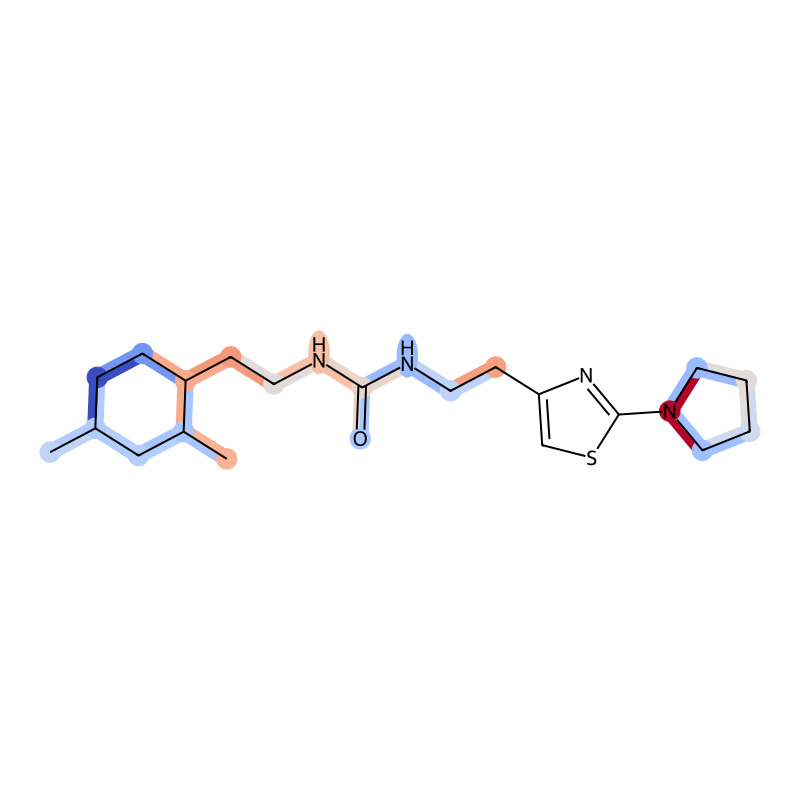

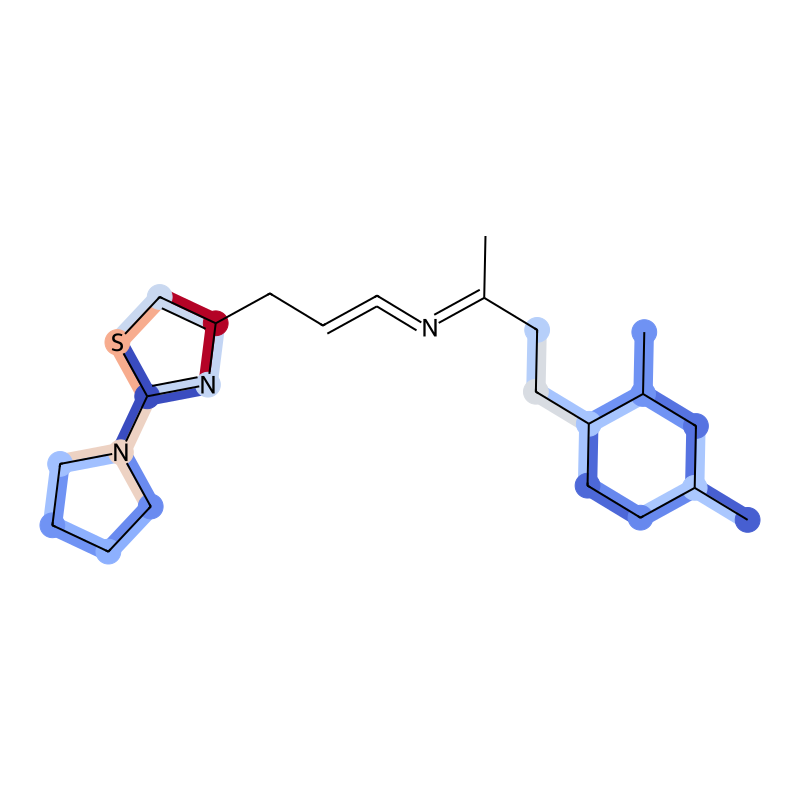

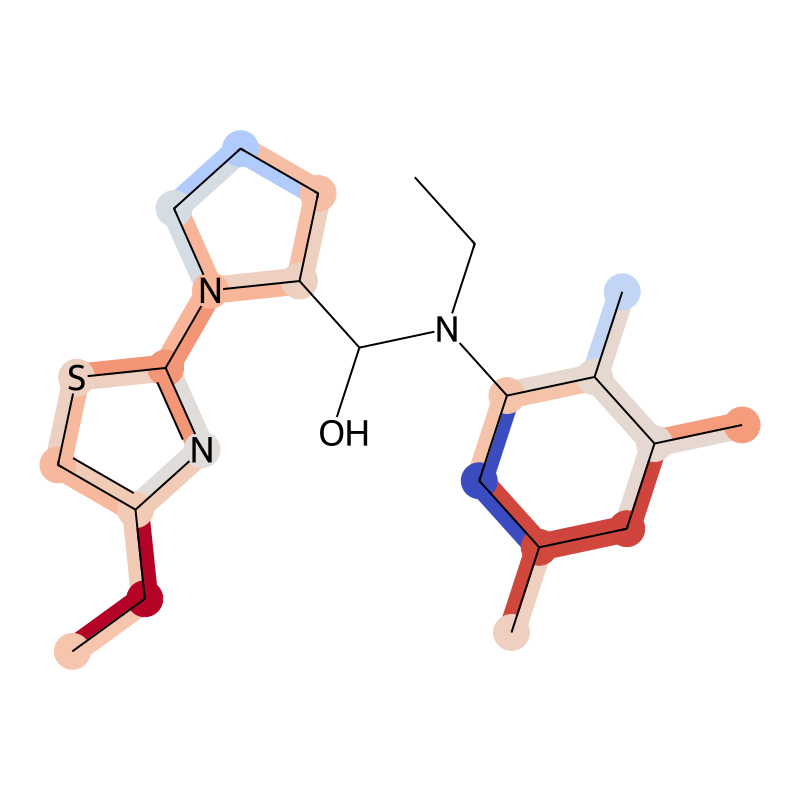

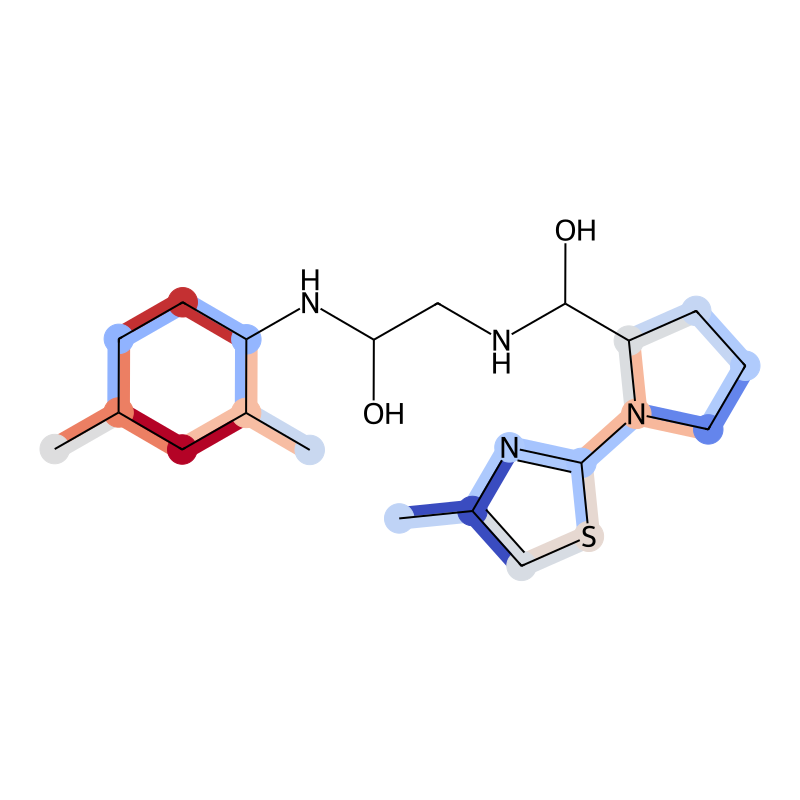

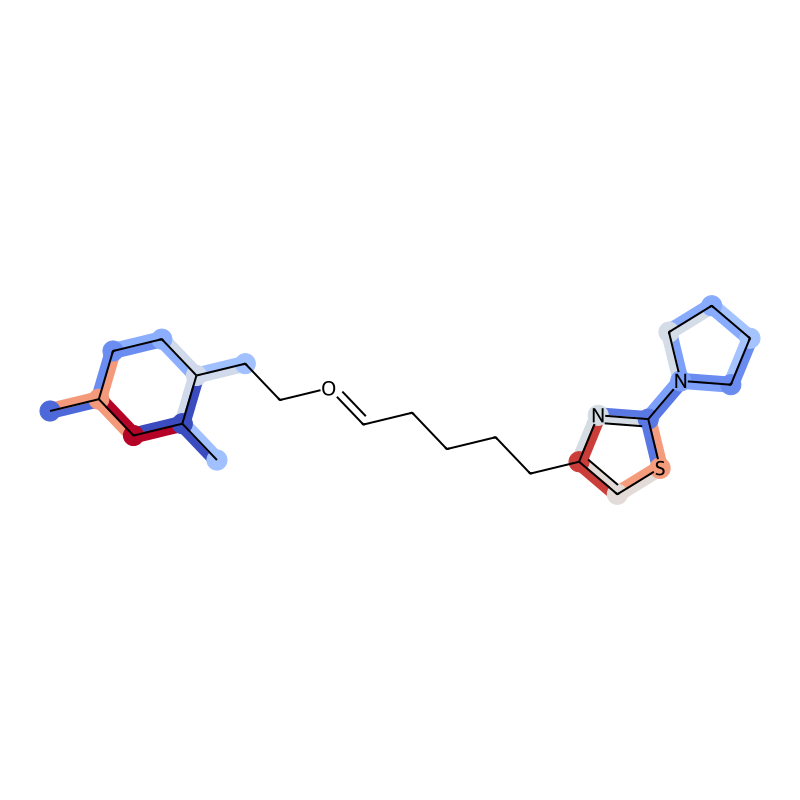

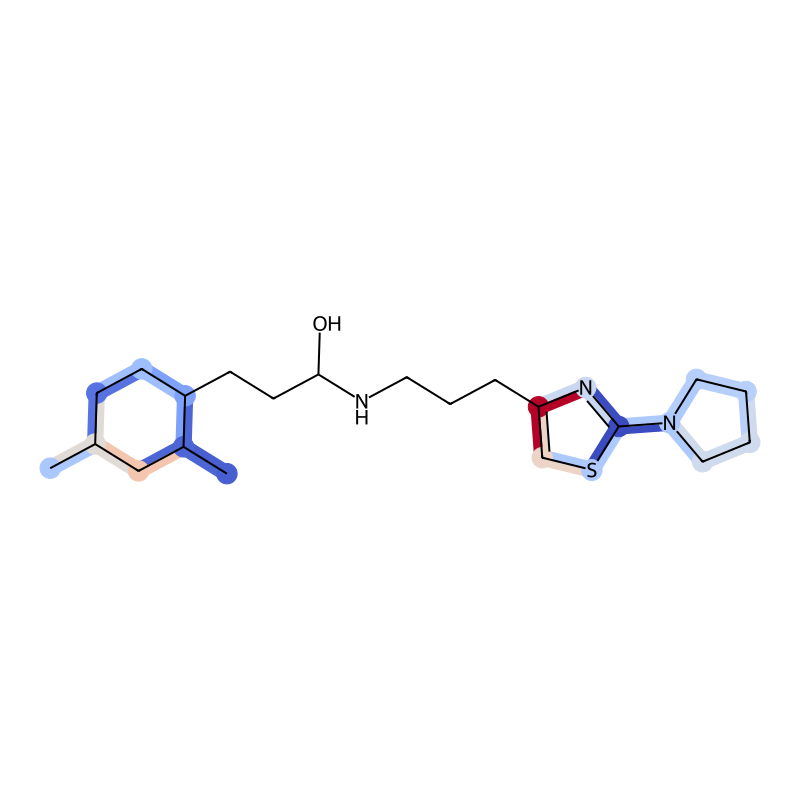

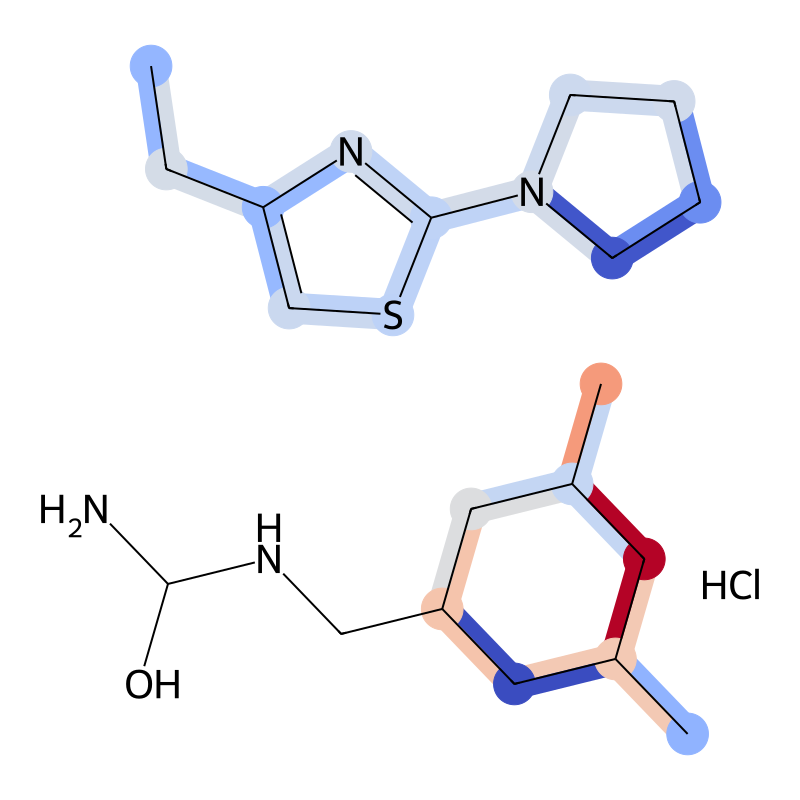

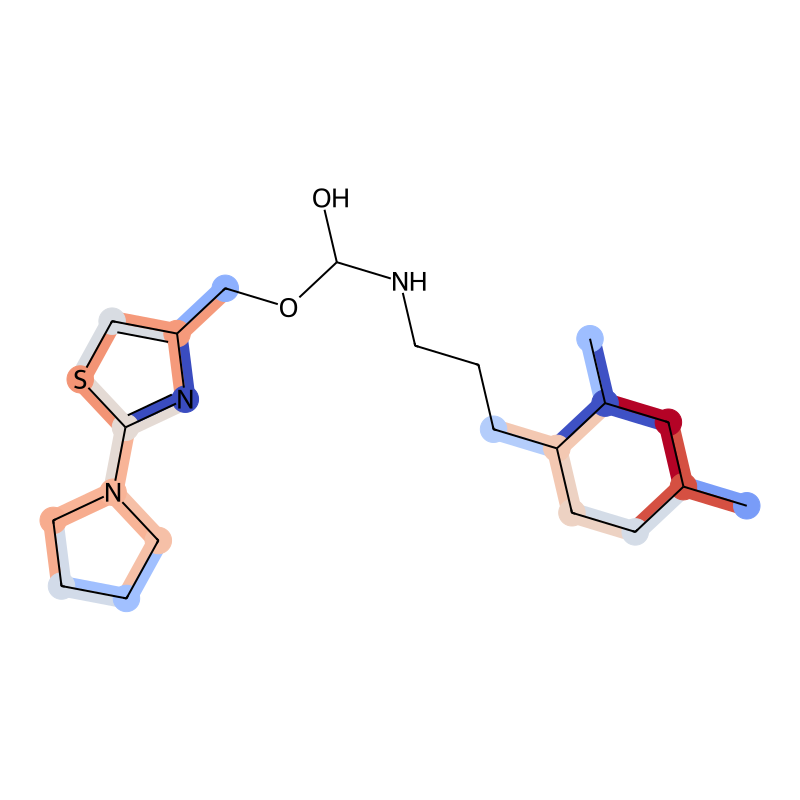

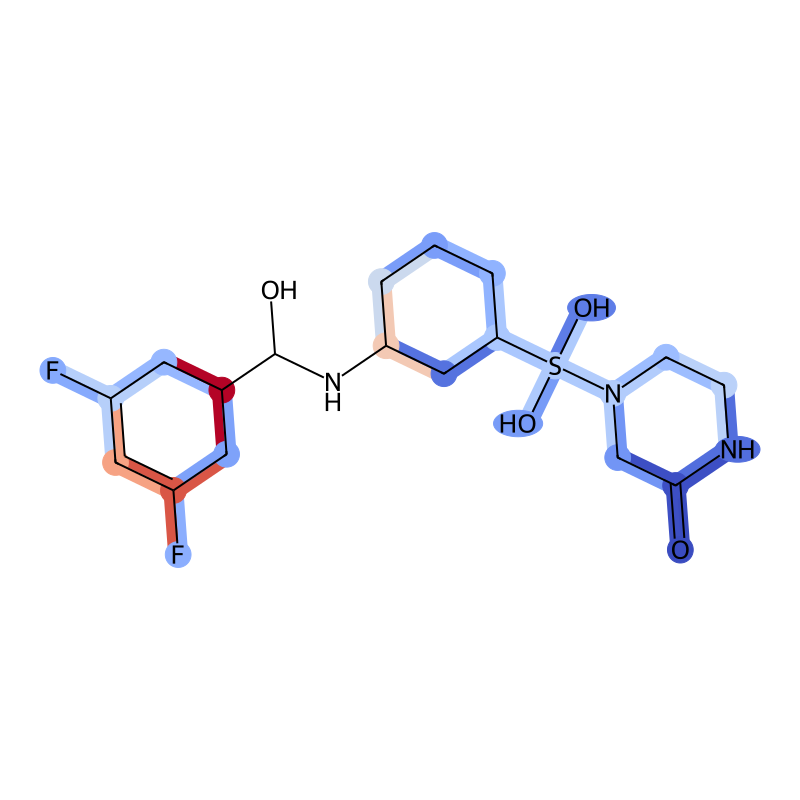

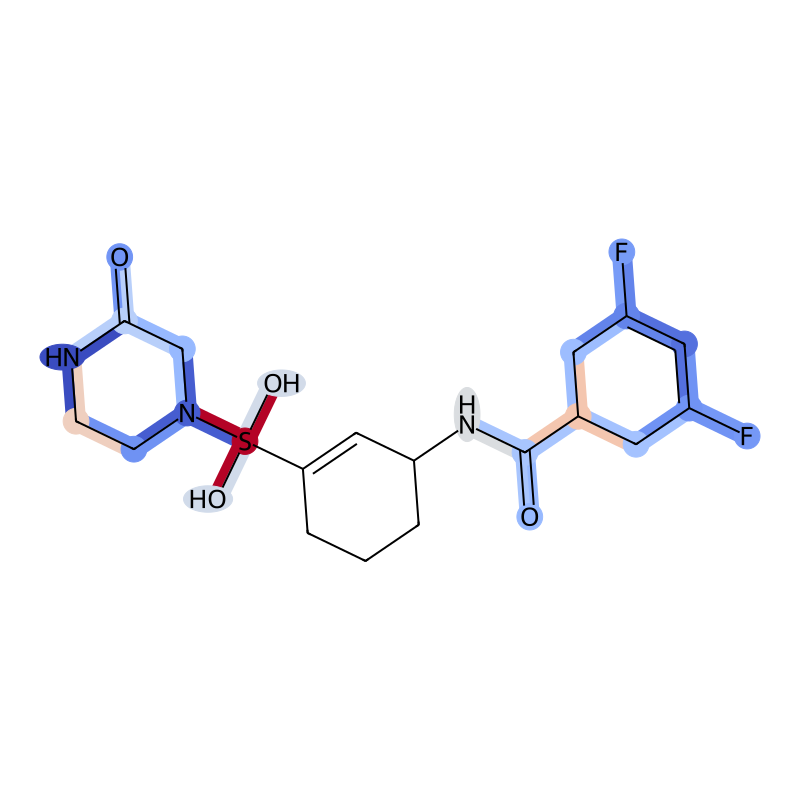

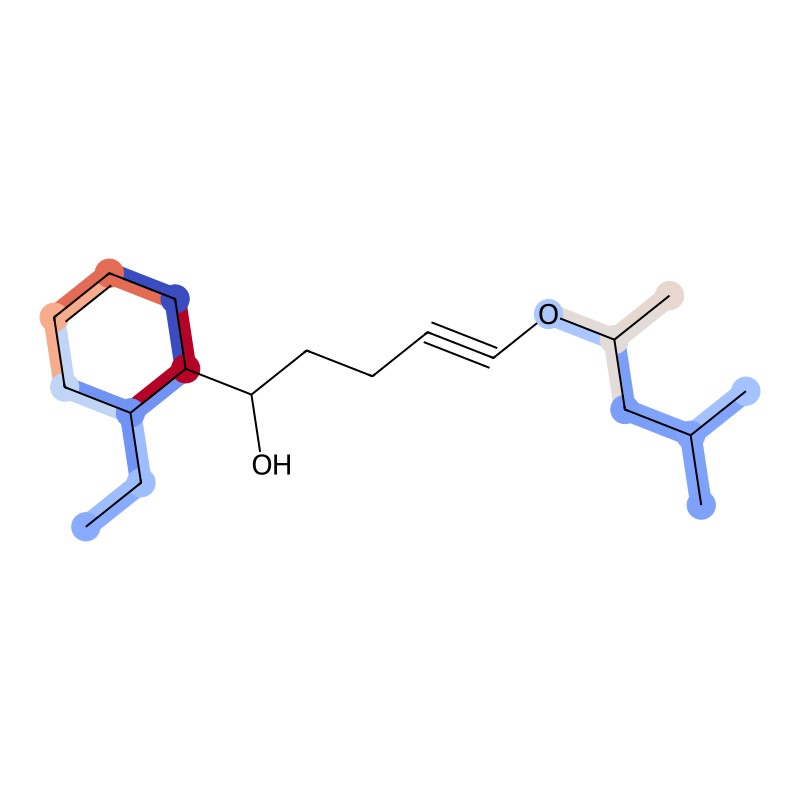

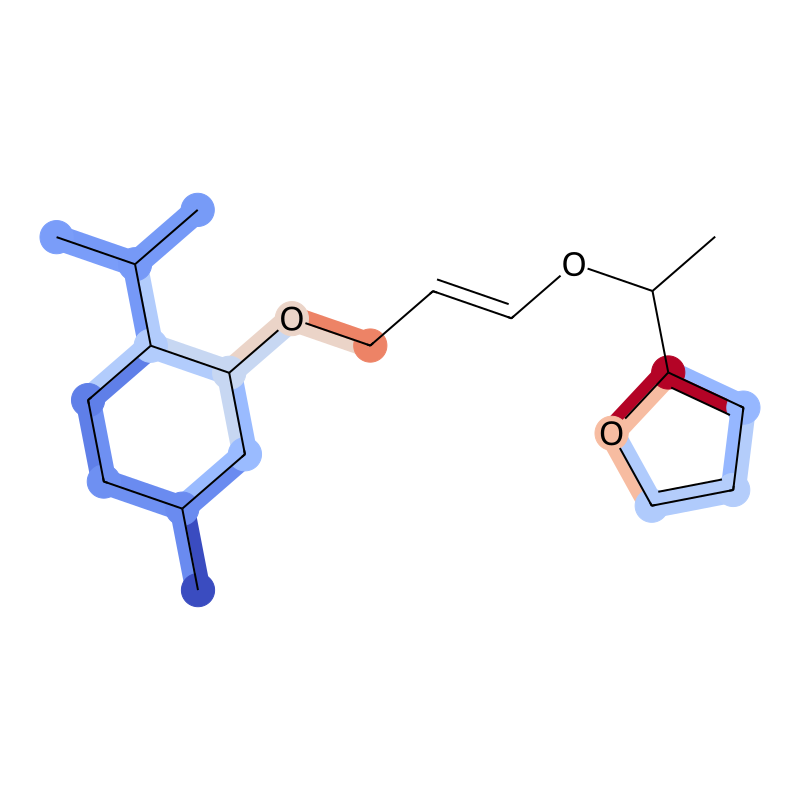

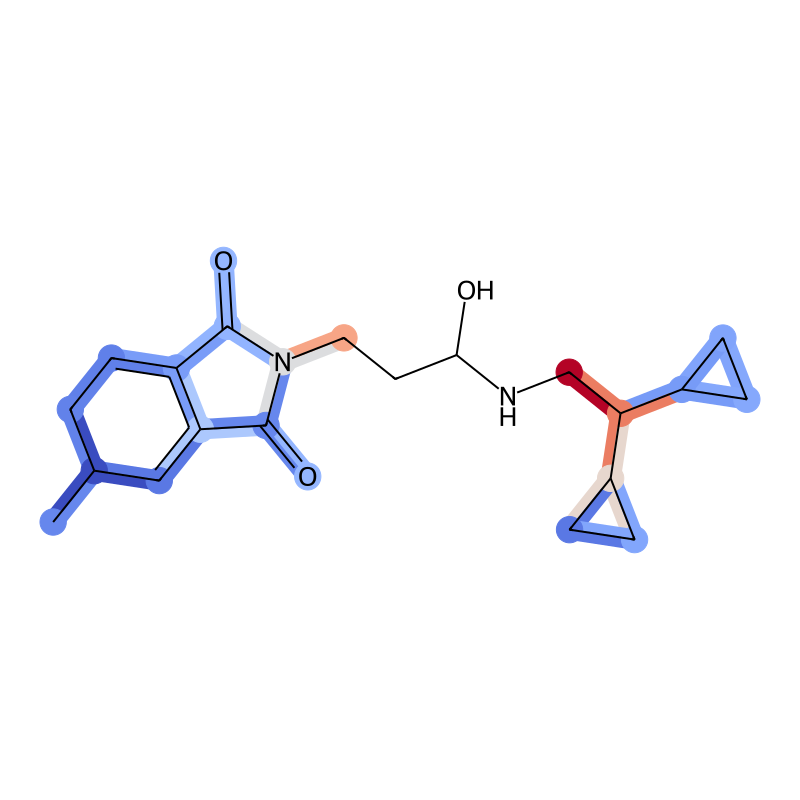

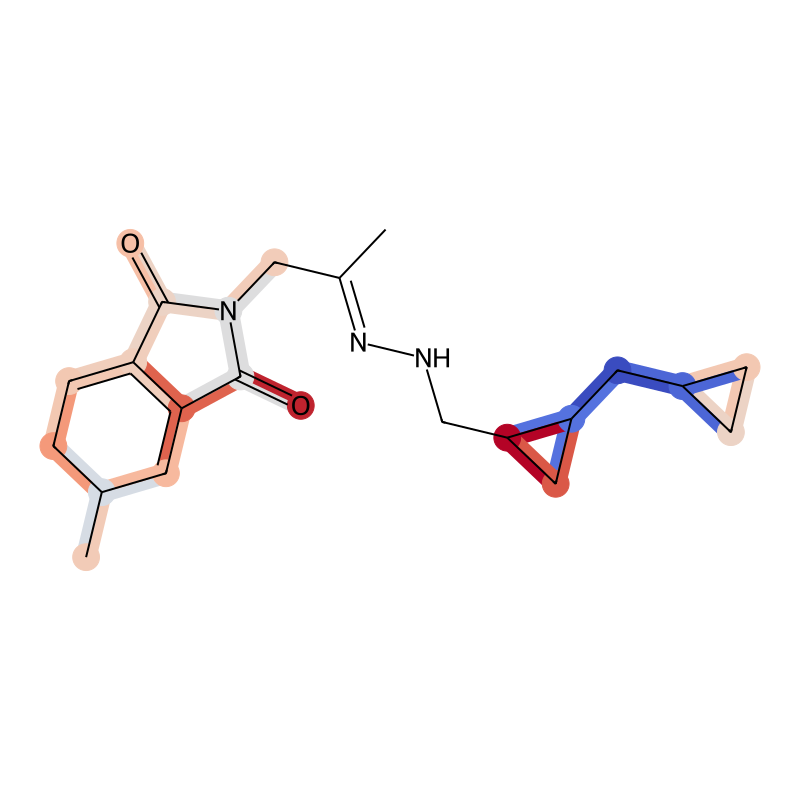

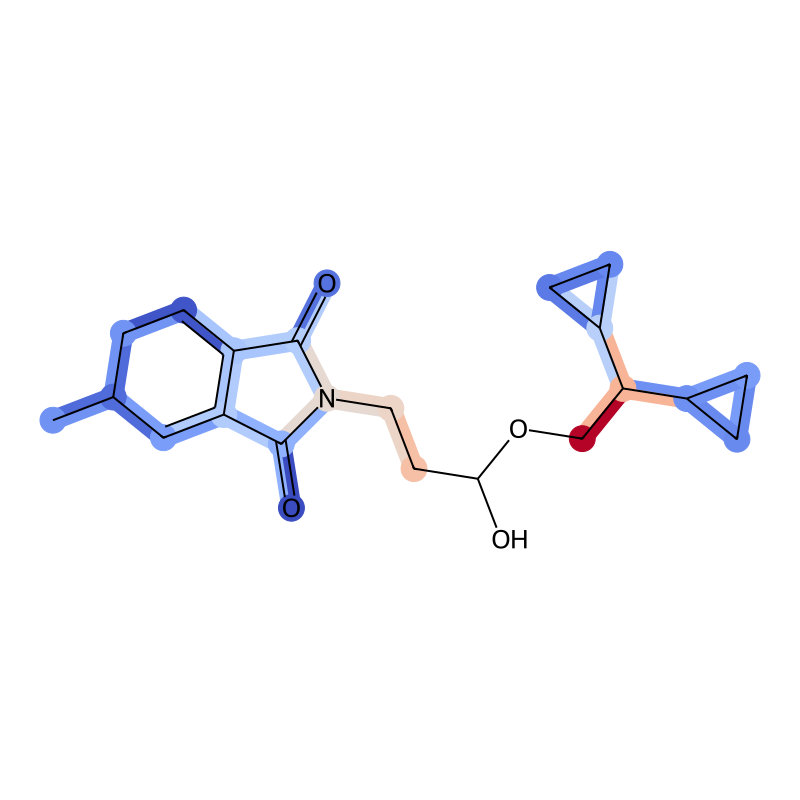

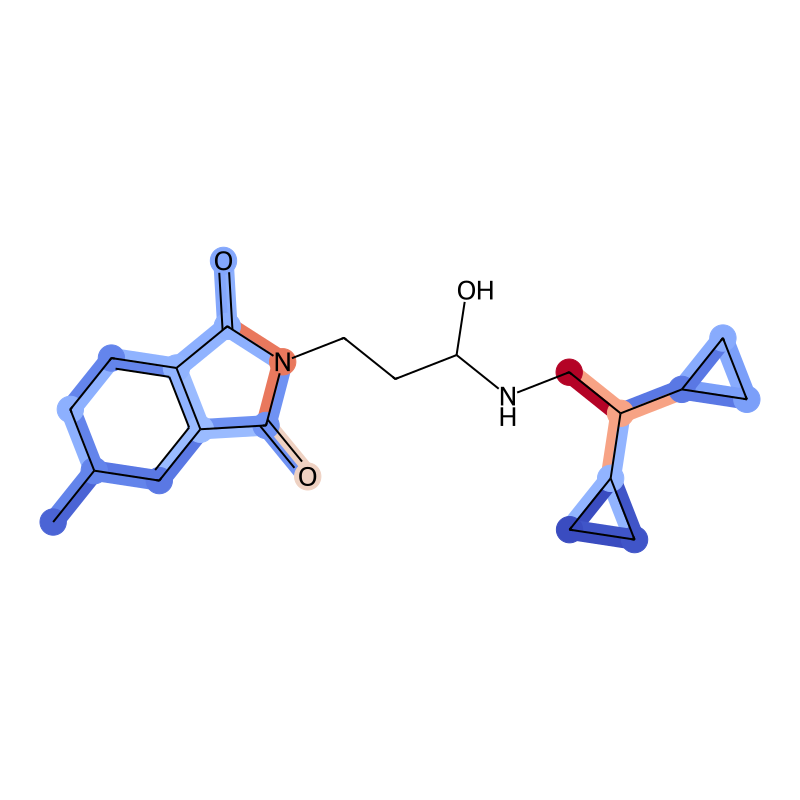

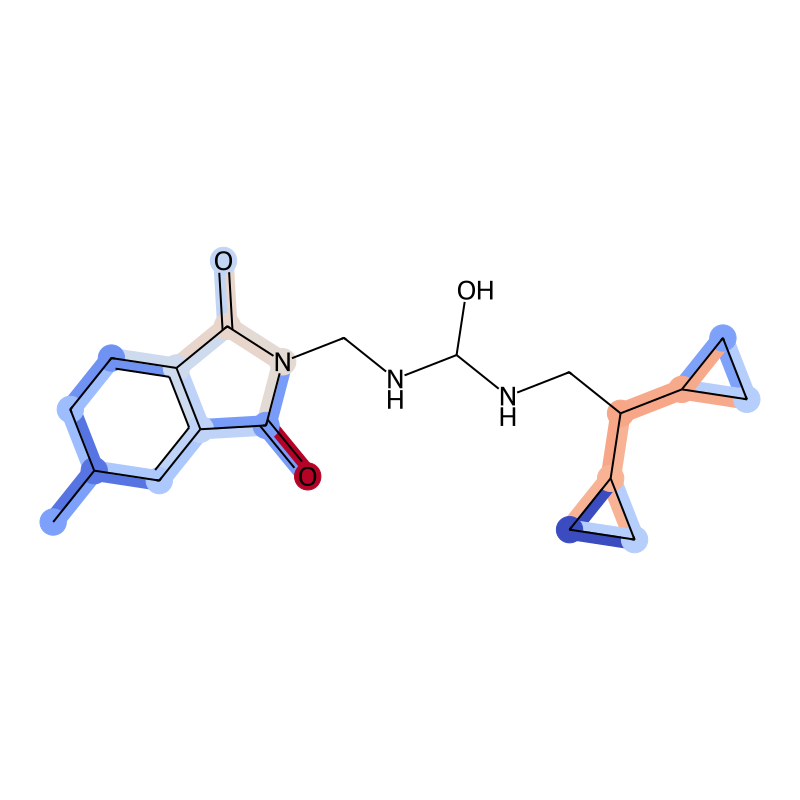

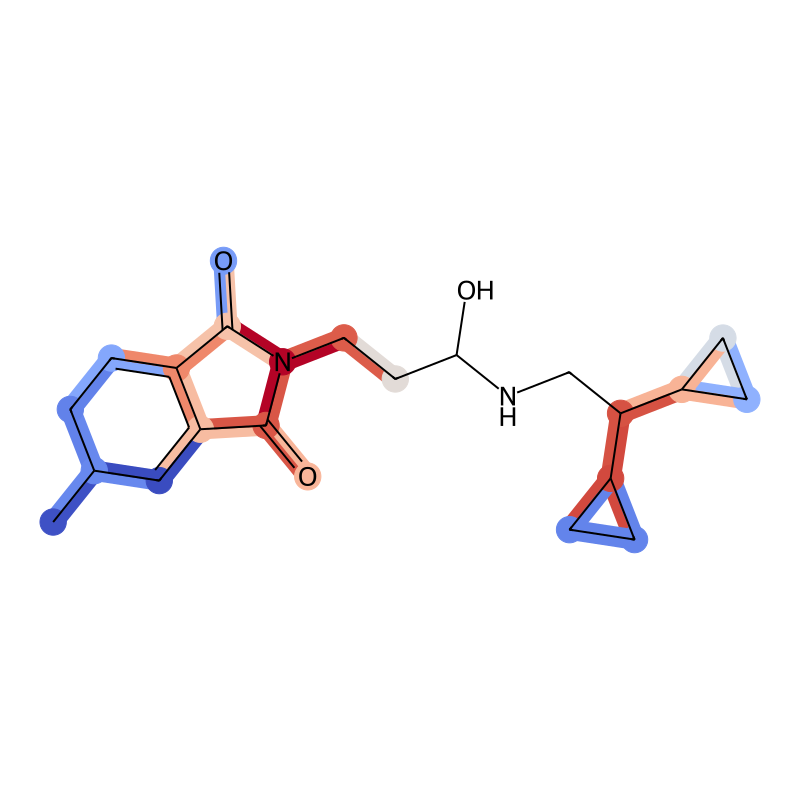

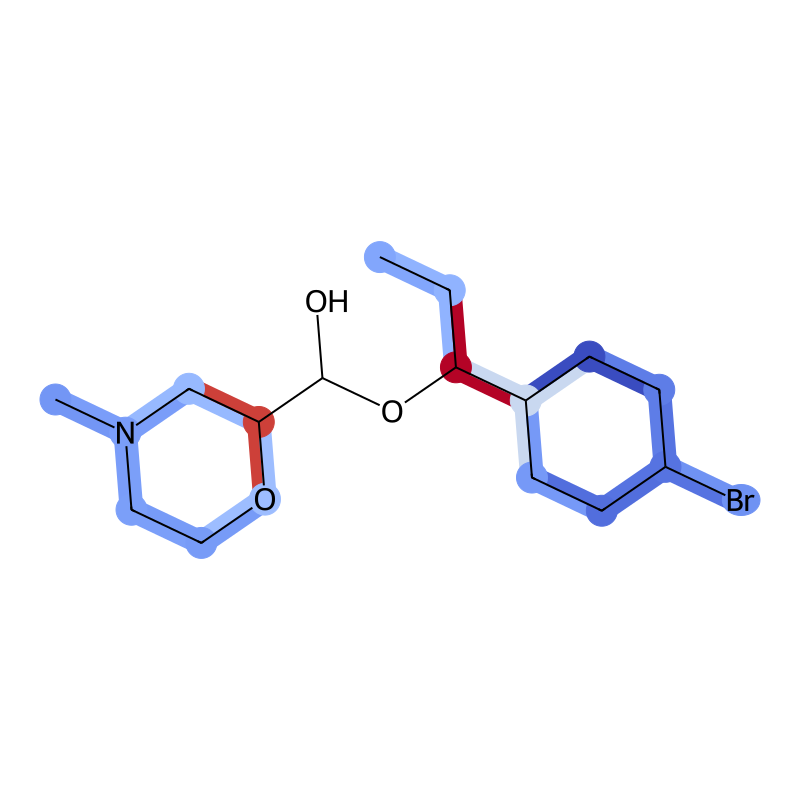

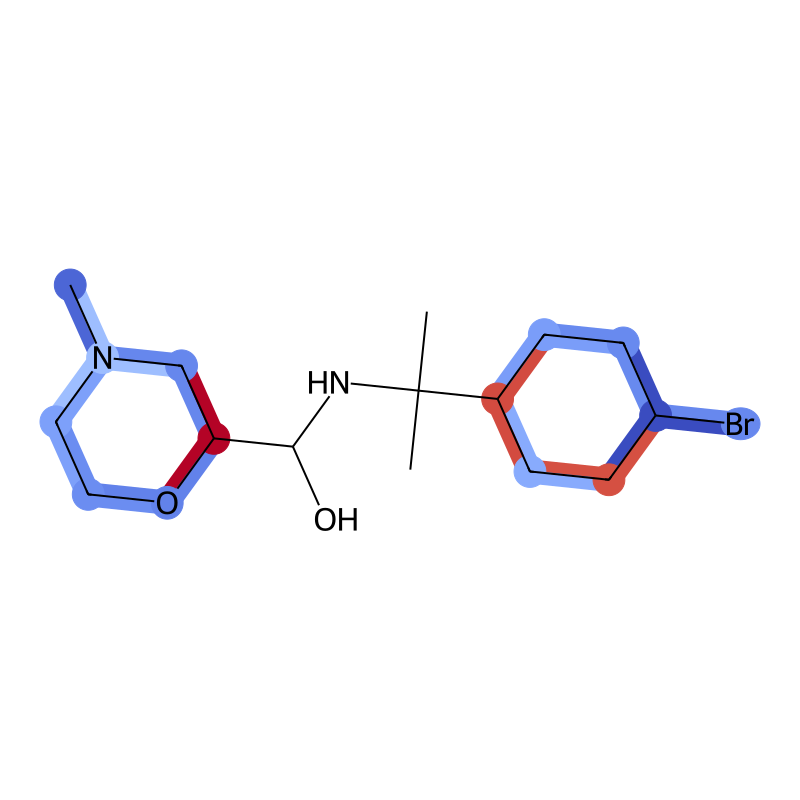

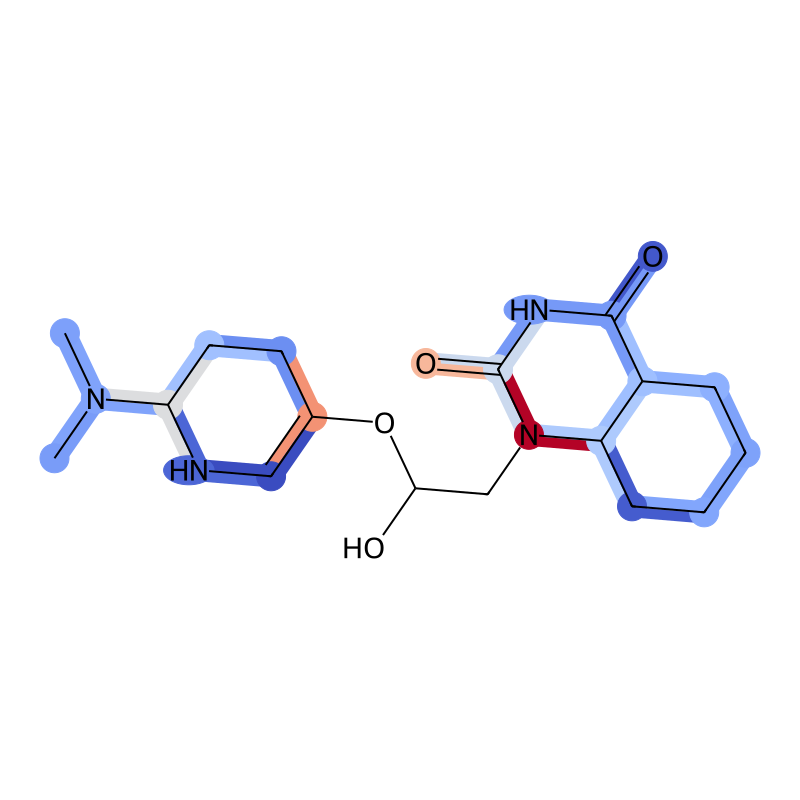

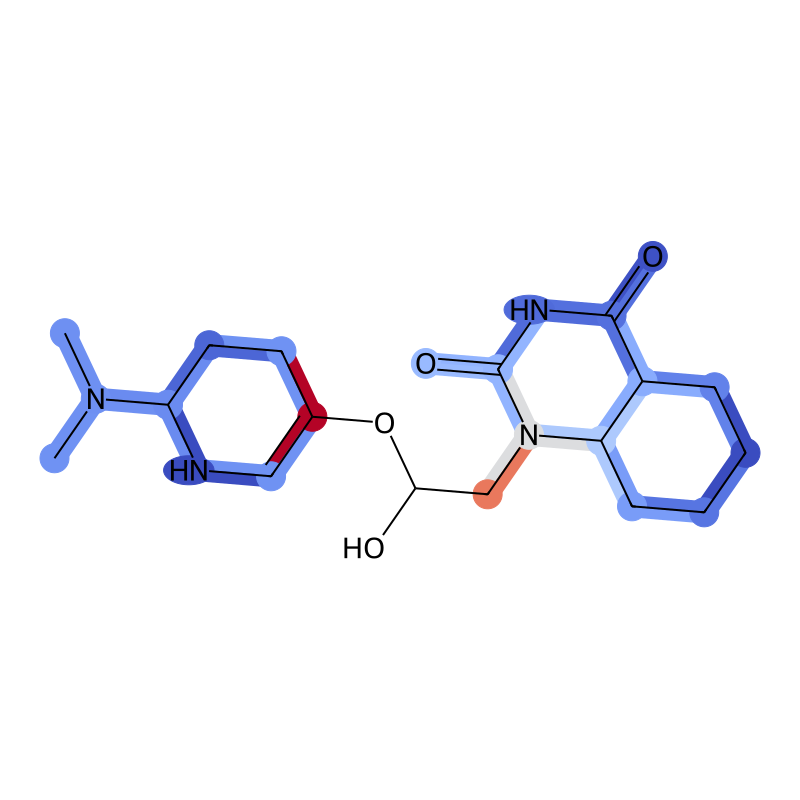

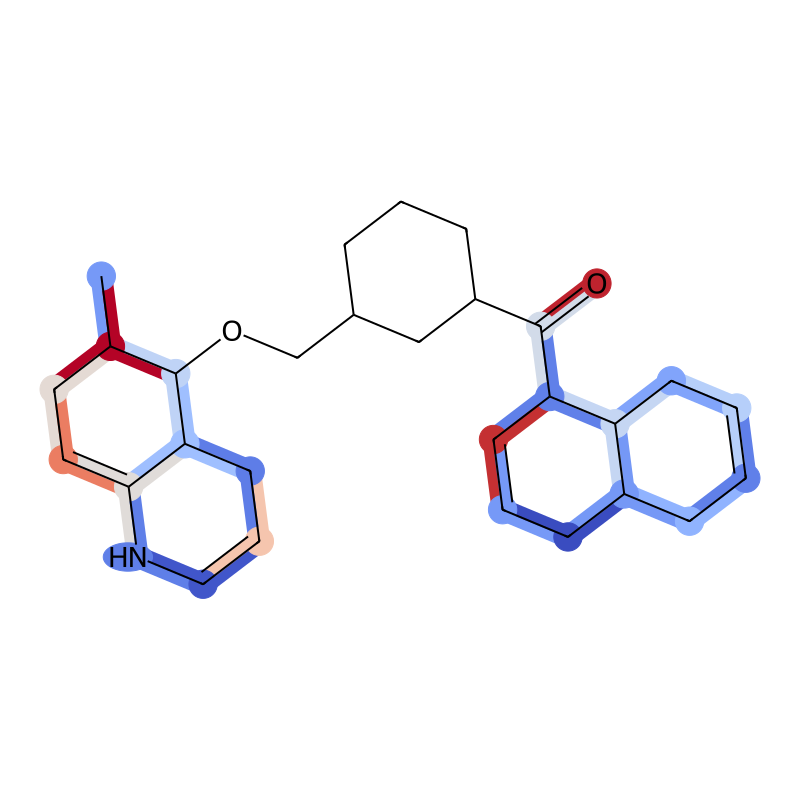

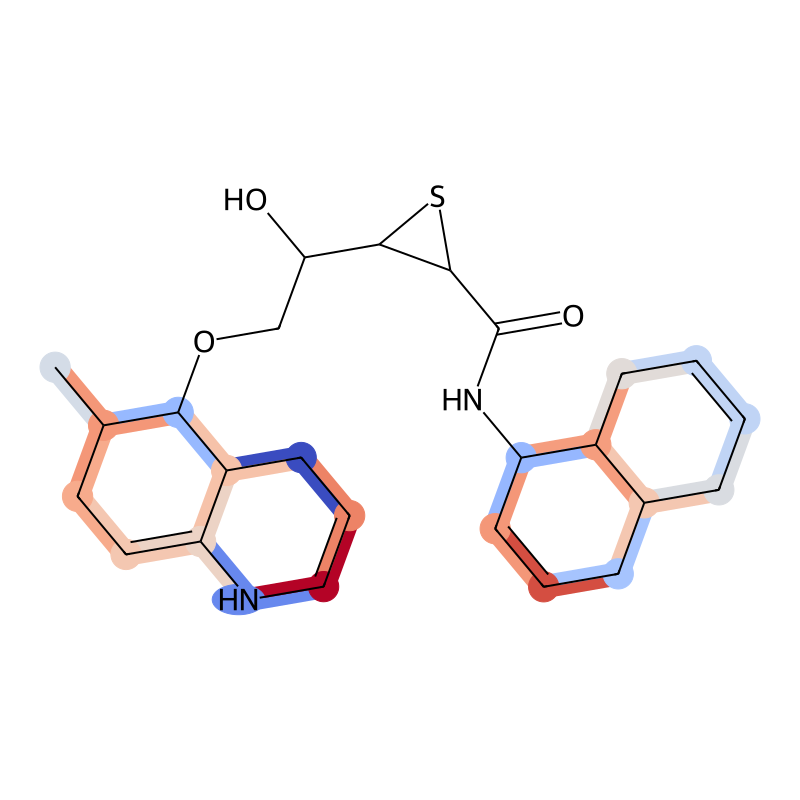

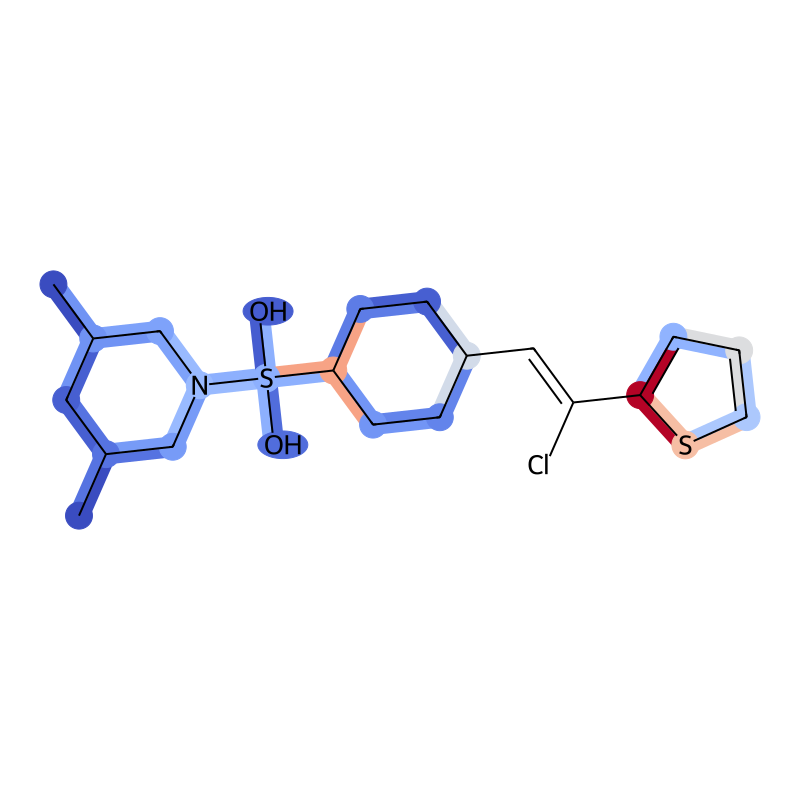

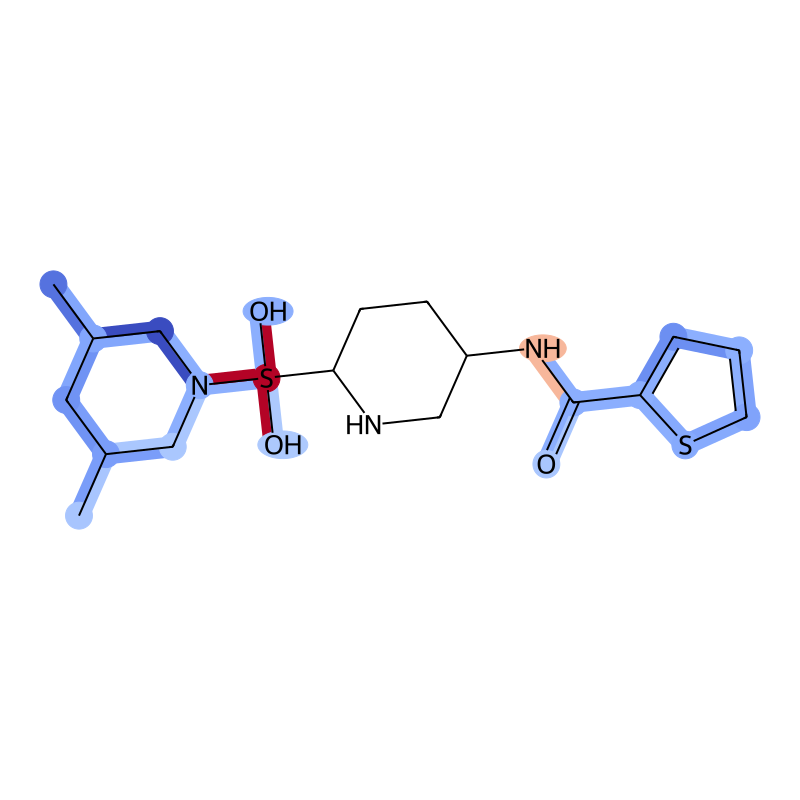

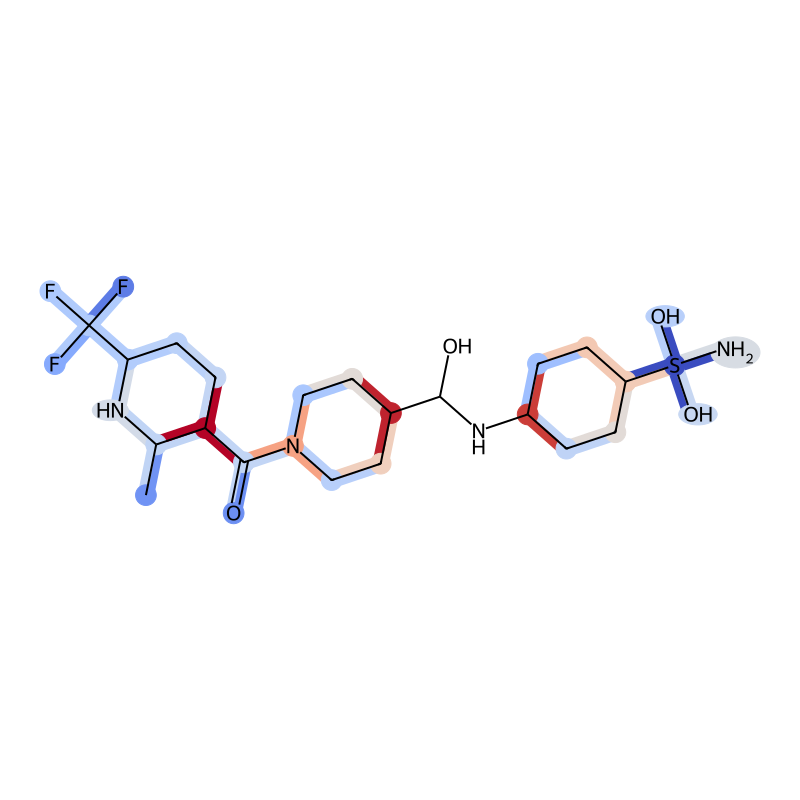

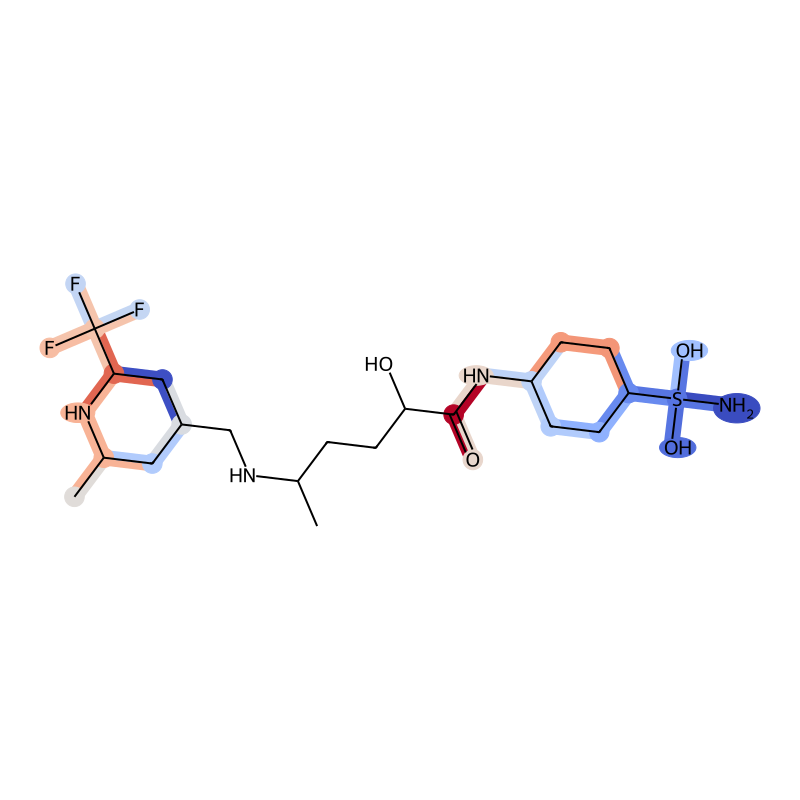

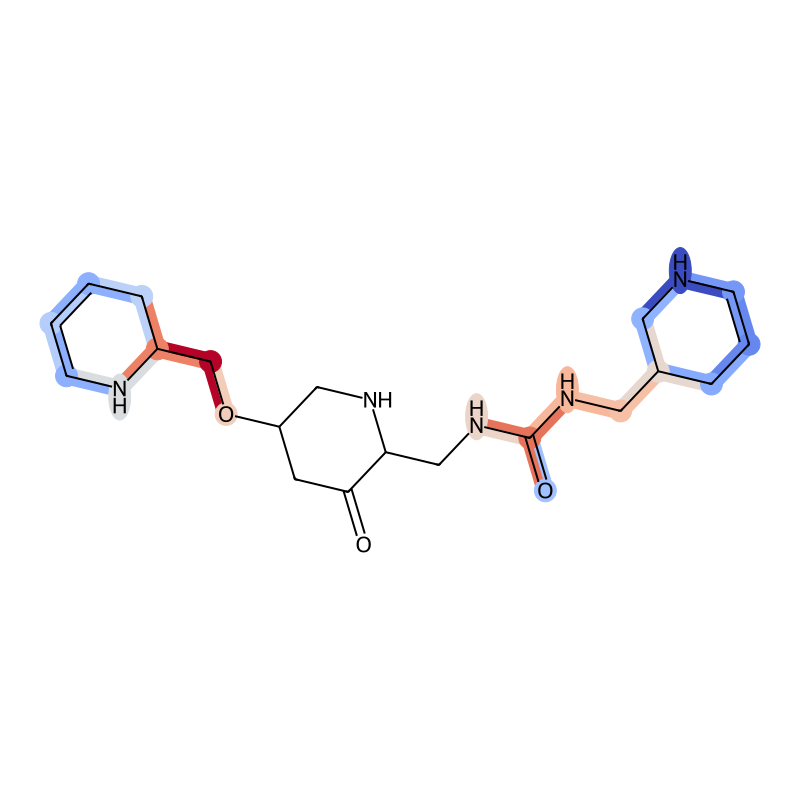

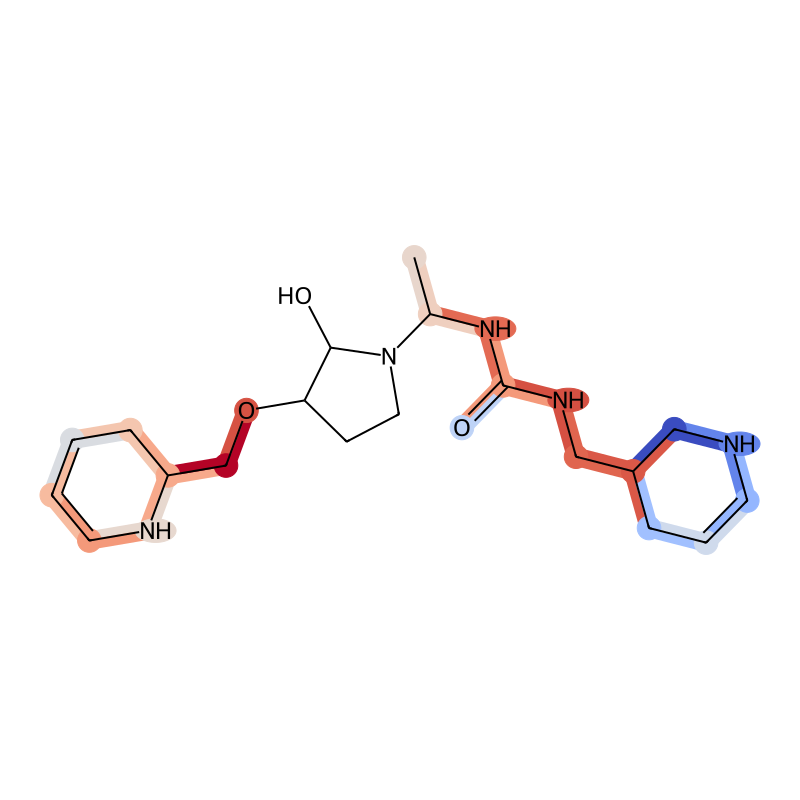

In [64]:
from collections import defaultdict
# Visualize generated molecules as molecular graphs
generated_folder = "trajectories/zinc_difflinker/zinc_final_test/final_states_hausdorff_distance_0.5_seed_42_no_transform_transformation_seed_42_COM_addition"

for data_index, data in enumerate(data_list):
    phi_values = shapley_values_all_dict[data_index][0]
    # Load generated molecule positions and atom types
    generated_file = os.path.join(generated_folder, f"{data_index}_pred_.xyz")
    positions, one_hot, _ = load_molecule_xyz(generated_file, is_geom=False)
    
    atom_types = torch.argmax(one_hot, dim=1).cpu().numpy()
   
    # Convert positions and atom types to an RDKit molecule
    mol = Chem.RWMol()
    atom_map = {}

    # Add atoms to the molecule
    for idx, atom_type in enumerate(atom_types):
        atom = Chem.Atom(IDX2ATOM[atom_type])
        atom_idx = mol.AddAtom(atom)
        atom_map[idx] = atom_idx

    # Add bonds based on positions and bond order
    for idx1 in range(len(positions)):
        for idx2 in range(idx1 + 1, len(positions)):
            dist = np.linalg.norm(positions[idx1] - positions[idx2])
            bond_order = get_bond_order(IDX2ATOM[atom_types[idx1]], IDX2ATOM[atom_types[idx2]], dist)
            if bond_order > 0:
                mol.AddBond(atom_map[idx1], atom_map[idx2], Chem.BondType.values[bond_order])

    # Highlight fragment atoms and edges
    fragment_mask = data['fragment_mask'][0].cpu().numpy()
   
    # Calculate the gradient colors based on phi values
    phi_values_array = np.array(phi_values)
    
    cmap = plt.cm.get_cmap('coolwarm_r') #reversed heatmap for distance-based importance
    norm = plt.Normalize(vmin=min(phi_values_array), vmax=max(phi_values_array))
    
    highlight_colors = {idx: cmap(norm(phi_values_array[idx])) for idx, mask in enumerate(fragment_mask) if mask == 1}
    
    highlight_atoms = list(highlight_colors.keys())
    highlight_bonds = []
    for bond in mol.GetBonds():
        if bond.GetBeginAtomIdx() in highlight_atoms and bond.GetEndAtomIdx() in highlight_atoms:
            highlight_bonds.append(bond.GetIdx())
    # Assign bond colors based on the colors of the connected atoms
    bond_colors = {}
    for bond in mol.GetBonds():
        begin_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        if begin_idx in highlight_colors and end_idx in highlight_colors:
            # Use the colors of the two connected atoms
            color1 = tuple(map(float, highlight_colors[begin_idx][:3]))  # Extract RGB values for atom 1
            color2 = tuple(map(float, highlight_colors[end_idx][:3]))  # Extract RGB values for atom 2 # Extract RGB values for atom 2
            bond_colors[bond.GetIdx()] = (color1, color2)  # Assign a tuple of two colors
    #uncomment for averaging colors
    # bond_colors = {}
    # for bond in mol.GetBonds():
    #     begin_idx = bond.GetBeginAtomIdx()
    #     end_idx = bond.GetEndAtomIdx()
    #     if begin_idx in highlight_colors and end_idx in highlight_colors:
    #         # Average the colors of the two connected atoms
    #         color1 = np.array(highlight_colors[begin_idx][:3])
    #         color2 = np.array(highlight_colors[end_idx][:3])
    #         averaged_color = tuple((color1 + color2) / 2)
    #         bond_colors[bond.GetIdx()] = averaged_color
    # Convert to RDKit molecule and draw
    mol = mol.GetMol()
    # atom_colors = {idx: tuple(color[:3]) for idx, color in highlight_colors.items()}  # Extract RGB values (remove alpha channel)
    atom_colors = {idx: list(map(float, color[:3])) for idx, color in highlight_colors.items()}  # Convert to lists of floats
    atom_colors = {key: [tuple(value)] for key, value in atom_colors.items()}
    bond_colors = {key: list(value) for key, value in bond_colors.items()}
    # Use DrawMoleculeWithHighlights for visualization
    drawer = Draw.MolDraw2DCairo(800, 800)
    draw_options = drawer.drawOptions()
    draw_options.useBWAtomPalette()
    drawer.DrawMoleculeWithHighlights(
        mol,
        "",  # Legend
        atom_colors,  # Atom colors (highlight_atom_map)
        bond_colors,  # Bond colors (highlight_bond_map)
        {},  # Atom radii
        {}  # Bond linewidth multipliers
        # confId=-1  # Default conformer ID
    )
    drawer.FinishDrawing()
    # Convert the drawing to a PNG image
    png_data = drawer.GetDrawingText()
    with open("temp_image.png", "wb") as f:
        f.write(png_data)

    # Load the PNG image using PIL
    img = Image.open("temp_image.png")
    
    img.show()
    
    # img.show()
    output_generated_dir = os.path.join(COORDINATES_FOLDER, "mappingnoaverage")
    os.makedirs(output_generated_dir, exist_ok=True)
    # Save the image in the "generated_structures" subfolder
    output_file = os.path.join(output_generated_dir, f"molecule_{data_index}.png")
    img.save(output_file, dpi=(300, 300))

In [46]:
# Convert each list of three floats in atom_colors into a tuple inside a list
atom_colors = {key: [tuple(value)] for key, value in atom_colors.items()}

In [61]:
# Convert the outer tuple in bond_colors into a list
bond_colors = {key: list(value) for key, value in bond_colors.items()}

In [62]:
bond_colors 

{0: [(0.8049647588235295, 0.8516661605568627, 0.9261650744313725),
  (0.8836871397764706, 0.8561077179529412, 0.8402576701764706)],
 1: [(0.8049647588235295, 0.8516661605568627, 0.9261650744313725),
  (0.6300885300352941, 0.7525162397058823, 0.9985080123411765)],
 2: [(0.8836871397764706, 0.8561077179529412, 0.8402576701764706),
  (0.5977767754941177, 0.7273297248823529, 0.9997767317764705)],
 3: [(0.5977767754941177, 0.7273297248823529, 0.9997767317764705),
  (0.705673158, 0.01555616, 0.150232812)],
 4: [(0.705673158, 0.01555616, 0.150232812),
  (0.6300885300352941, 0.7525162397058823, 0.9985080123411765)],
 6: [(0.753610618, 0.830232851, 0.960871157),
  (0.6933212848235294, 0.7963141317058823, 0.9863077805294118)],
 7: [(0.6933212848235294, 0.7963141317058823, 0.9863077805294118),
  (0.2298057, 0.298717966, 0.753683153)],
 8: [(0.6933212848235294, 0.7963141317058823, 0.9863077805294118),
  (0.7087196897176471, 0.8057213889294117, 0.9811168090470588)],
 9: [(0.2298057, 0.298717966, 0.

In [58]:
bond_colors

{0: [<map at 0x7f0ac17ffaf0>,
  [0.8836871397764706, 0.8561077179529412, 0.8402576701764706]],
 1: [<map at 0x7f0ac17fc0d0>,
  [0.6300885300352941, 0.7525162397058823, 0.9985080123411765]],
 2: [<map at 0x7f0ac17fc610>,
  [0.5977767754941177, 0.7273297248823529, 0.9997767317764705]],
 3: [<map at 0x7f0ac17ff010>, [0.705673158, 0.01555616, 0.150232812]],
 4: [<map at 0x7f0ac17ffcd0>,
  [0.6300885300352941, 0.7525162397058823, 0.9985080123411765]],
 6: [<map at 0x7f0ac17feaa0>,
  [0.6933212848235294, 0.7963141317058823, 0.9863077805294118]],
 7: [<map at 0x7f0ac17fe830>, [0.2298057, 0.298717966, 0.753683153]],
 8: [<map at 0x7f0ac17fde40>,
  [0.7087196897176471, 0.8057213889294117, 0.9811168090470588]],
 9: [<map at 0x7f0ac17fe020>,
  [0.45173856047058825, 0.5881809882352941, 0.9602012675882353]],
 10: [<map at 0x7f0ac17ffbe0>,
  [0.968105337, 0.668475196117647, 0.5504862209411765]],
 11: [<map at 0x7f0ac17fea40>,
  [0.9566532109764706, 0.598033822717647, 0.4773022923529412]],
 12: [<map

In [47]:
atom_colors

{0: [(0.8049647588235295, 0.8516661605568627, 0.9261650744313725)],
 1: [(0.8836871397764706, 0.8561077179529412, 0.8402576701764706)],
 2: [(0.5977767754941177, 0.7273297248823529, 0.9997767317764705)],
 3: [(0.705673158, 0.01555616, 0.150232812)],
 4: [(0.6300885300352941, 0.7525162397058823, 0.9985080123411765)],
 5: [(0.753610618, 0.830232851, 0.960871157)],
 6: [(0.6933212848235294, 0.7963141317058823, 0.9863077805294118)],
 7: [(0.2298057, 0.298717966, 0.753683153)],
 8: [(0.45173856047058825, 0.5881809882352941, 0.9602012675882353)],
 9: [(0.968105337, 0.668475196117647, 0.5504862209411765)],
 10: [(0.9566532109764706, 0.598033822717647, 0.4773022923529412)],
 11: [(0.8836871397764706, 0.8561077179529412, 0.8402576701764706)],
 12: [(0.9637718182823529, 0.749085510572549, 0.6494200432901961)],
 13: [(0.9094595977529412, 0.8393864797647058, 0.8003313524235294)],
 14: [(0.6619678959411764, 0.7754914668823529, 0.9939365253764706)],
 15: [(0.5977767754941177, 0.7273297248823529, 0.9